# Utility functions and tests (to be integrated w/ source code)


In [2]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import y0
import nocap
from IPython.display import Latex
import json
import os
import pandas as pd
import re
import fileinput
import sys
import shutil
import re

# you may need to fix  error w/ causalgraphicalmodels and new python versions
# change "from collections import Iterable" to "from collections.abc import Iterable" in cgm.py

# Path to the cgm.py file (update this to the correct path on your system)
# cgm_file_path = "/path/to/causalgraphicalmodels/cgm.py"

# shutil.copyfile(cgm_file_path, cgm_file_path + ".bak")  # Create a backup of the original file

# Replace the import statement
# with fileinput.FileInput(cgm_file_path, inplace=True) as file:
#     for line in file:
#         print(line.replace("from collections import Iterable", "from collections.abc import Iterable"), end='')


from causalgraphicalmodels import CausalGraphicalModel

### parse a biocyc network regulation text file and convert it into a networkx directed graph

In [3]:
def parse_regulation_file(file_path):
    "Parses a biocyc network regulation text file and converts it into a directed graph."
    # Regulation text file should have the following format: 
    # '#' for comments.
    # All regulators have a "*" after their name.
    # Top level (master) regulators are not indented. 
    # descendants of the regulator are indented and spaced on the subsequent line. 
    # The regulatees are prefixed with a '+', '-', or '+/-' for polarity.


    # Create a directed graph to represent the network
    G = nx.DiGraph()

    # Open and read the file line by line
    with open(file_path, 'r') as file:
        current_regulator = None  # Initialize the current regulator variable
        for line in file:
            # Ignore lines starting with '#' or that are empty
            if line.startswith('#') or not line.strip():
                continue

            # Remove trailing whitespace from the line
            line = line.rstrip()

            # Check if a line does not start with an indent and also ends with an asterisk
            if not line.startswith('  ') and line.endswith('*'):
                # Remove the asterisk and set that as the current_regulator
                current_regulator = line[:-1].strip()
                # Make first letter uppercase
                current_regulator = current_regulator[0].upper() + current_regulator[1:]
                # If the current regulator is not already in the graph, add it
                if current_regulator not in G:
                    G.add_node(current_regulator)
            elif current_regulator and line.startswith('  '):
                # Process the regulatees
                regulatees = line.strip().split()
                for regulatee in regulatees:
                    # Determine the polarity and adjust slicing accordingly
                    if regulatee.startswith('+/-'):
                        polarity = '+/-'
                        gene = regulatee[3:]
                    elif regulatee.startswith('+') or regulatee.startswith('-'):
                        polarity = regulatee[0]
                        gene = regulatee[1:]
                    else:
                        print(f'regulatee: {regulatee} has no polarity')
                        polarity = ''
                        gene = regulatee

                    # Remove the trailing asterisk if present
                    gene = gene.rstrip('*')
                    # Make first letter uppercase
                    gene = gene[0].upper() + gene[1:]

                    # If the regulatee is not in the graph, add it
                    if gene not in G:
                        G.add_node(gene)
                    # Add an edge between the current_regulator and the regulatee with the polarity as an attribute
                    G.add_edge(current_regulator, gene, polarity=polarity)
    return G



def test_parse_regulation_file_simple():
    "Checks that the expected and actual graphs are identical after parsing."
    # Path to the file with the regulation data
    file_path = 'simple_regulation_network.txt'
    
    # Parse the file using the function
    G = parse_regulation_file(file_path)
    
    # Define the expected graph structure
    expected_G = nx.DiGraph()
    expected_G.add_edges_from([
        ('GeneA', 'GeneA', {'polarity': '+'}),
        ('GeneA', 'GeneB', {'polarity': '+'}),
        ('GeneA', 'GeneC', {'polarity': '+'}),
        ('GeneB', 'GeneB', {'polarity': '-'}),
        ('GeneB', 'GeneC', {'polarity': ''}),
        ('GeneC', 'GeneD', {'polarity': '+/-'}),
    ])
    
    # Assert that the two graphs are equal
    assert nx.is_isomorphic(G, expected_G, edge_match=nx.algorithms.isomorphism.categorical_edge_match('polarity', None)), "The graphs are not isomorphic or the edge polarities do not match."
    print("test_parse_regulation_file_simple test passed.")

# Call the test function
test_parse_regulation_file_simple()

regulatee: geneC* has no polarity
test_parse_regulation_file_simple test passed.


### convert cyclic directed graph into acyclic directed graph

In [4]:
def convert_to_acyclic_graph(graph):
    """Converts a (cyclic) directed graph into an acyclic directed graph by removing edges and disconnected nodes."""
    G = graph.copy()

    # Remove self-loops
    self_loops = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loops)

    # Remove nodes that became disconnected after removing self-loops
    for u, v in self_loops:
        if G.degree(u) == 0:
            G.remove_node(u)

    # If the graph is still cyclic, find and break the cycles
    if not nx.is_directed_acyclic_graph(G):
        cycles = list(nx.simple_cycles(G))
        for cycle in cycles:
            # Remove one edge from the cycle
            G.remove_edge(cycle[-1], cycle[0])
            # Remove nodes that became disconnected after removing the edge
            if G.degree(cycle[-1]) == 0:
                G.remove_node(cycle[-1])
            if G.degree(cycle[0]) == 0:
                G.remove_node(cycle[0])

    return G


def test_convert_to_acyclic_graph():
    """Tests if a graph is correctly converted into an acyclic graph."""
    # Create a directed graph representing a simple gene regulatory network
    cyclic_graph = nx.DiGraph()
    cyclic_graph.add_edges_from([
        ('Gene1', 'Gene2'),  # Gene1 activates Gene2
        ('Gene2', 'Gene3'),  # Gene2 activates Gene3
        ('Gene3', 'Gene1'),  # Gene3 activates Gene1, forming a cycle
        ('Gene3', 'Gene3'),  # Gene3 regulates itself, a self-loop
        ('Gene4', 'Gene2'),  # Gene4 activates Gene2, not part of a cycle
    ])

    # Convert the cyclic graph to an acyclic one
    acyclic_graph = convert_to_acyclic_graph(cyclic_graph)

    # Test if the resulting graph is acyclic
    assert nx.is_directed_acyclic_graph(acyclic_graph), "The graph is not acyclic."

    # Test if the self-loop has been removed
    assert not acyclic_graph.has_edge('Gene3', 'Gene3'), "The self-loop has not been removed."

    # Test if the larger cycle has been broken by checking for cycles
    assert len(list(nx.simple_cycles(acyclic_graph))) == 0, "The cycle has not been broken."

    # Test if non-cycle edges are preserved
    assert acyclic_graph.has_edge('Gene4', 'Gene2'), "The edge not part of a cycle was incorrectly removed."
    print("test_convert_to_acyclic_graph test passed.")

test_convert_to_acyclic_graph()

test_convert_to_acyclic_graph test passed.


In [5]:
def convert_to_acyclic_graph_dfs(graph):
    """Converts a (cyclic) directed graph into an acyclic directed graph using depth-first search to remove back edges."""
    G = graph.copy()
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    dfs_edges = list(nx.dfs_edges(G))
    back_edges = set(G.edges()) - set(dfs_edges)
    G.remove_edges_from(back_edges)
    
    # Keep only the largest strongly connected component
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    for node in set(G.nodes()) - largest_scc:
        G.remove_node(node)
    
    return G

def test_convert_to_acyclic_graph_dfs():
    """Tests if a graph is correctly converted into an acyclic graph using depth-first search."""
    # Create a directed graph representing a simple gene regulatory network
    cyclic_graph = nx.DiGraph()
    cyclic_graph.add_edges_from([
        ('Gene1', 'Gene2'),
        ('Gene2', 'Gene3'),
        ('Gene3', 'Gene1'),  # Cycle
        ('Gene3', 'Gene3'),  # Self-loop
        ('Gene4', 'Gene2'),  # Not part of a cycle
    ])

    # Convert the cyclic graph to an acyclic one using depth-first search
    acyclic_graph_dfs = convert_to_acyclic_graph_dfs(cyclic_graph)

    # Test if the resulting graph is acyclic
    assert nx.is_directed_acyclic_graph(acyclic_graph_dfs), "The graph is not acyclic."

    # Test if the resulting graph has no self-loops
    assert not list(nx.selfloop_edges(acyclic_graph_dfs)), "The graph has self-loops."

    # Test if the resulting graph is strongly connected
    assert nx.is_strongly_connected(acyclic_graph_dfs), "The graph is not strongly connected."

     # Test case 2: Graph with multiple separate cycles
    cyclic_graph2 = nx.DiGraph()
    cyclic_graph2.add_edges_from([
        ('Gene1', 'Gene2'),
        ('Gene2', 'Gene1'),  # Cycle 1
        ('Gene3', 'Gene4'),
        ('Gene4', 'Gene3'),  # Cycle 2
    ])
    acyclic_graph2 = convert_to_acyclic_graph(cyclic_graph2)
    assert nx.is_directed_acyclic_graph(acyclic_graph2), "The graph is not acyclic."

    # Test case 3: Graph with nested cycles
    cyclic_graph3 = nx.DiGraph()
    cyclic_graph3.add_edges_from([
        ('Gene1', 'Gene2'),
        ('Gene2', 'Gene3'),
        ('Gene3', 'Gene1'),  # Outer cycle
        ('Gene2', 'Gene4'),
        ('Gene4', 'Gene2'),  # Inner cycle
    ])
    acyclic_graph3 = convert_to_acyclic_graph(cyclic_graph3)
    assert nx.is_directed_acyclic_graph(acyclic_graph3), "The graph is not acyclic."

    # Test case 4: Graph with a single node
    cyclic_graph4 = nx.DiGraph()
    cyclic_graph4.add_node('Gene1')
    acyclic_graph4 = convert_to_acyclic_graph(cyclic_graph4)
    assert nx.is_directed_acyclic_graph(acyclic_graph4), "The graph is not acyclic."

    print("All assertions passed for convert_to_acyclic_graph.")

# Run the test function
test_convert_to_acyclic_graph()


test_convert_to_acyclic_graph_dfs()


test_convert_to_acyclic_graph test passed.
All assertions passed for convert_to_acyclic_graph.


In [6]:
def convert_to_acyclic_graph_fancy(graph, target_node):
    """Converts a (cyclic) directed graph into an acyclic directed graph by removing edges and disconnected nodes."""
    G = graph.copy()

    # Get all descendants of the target node
    descendants = nx.descendants(G, target_node)

    # Find all edges in shortest paths from the target node to its descendants
    edges_in_paths = set()
    for descendant in descendants:
        path = nx.shortest_path(G, target_node, descendant)
        edges_in_path = list(zip(path, path[1:]))
        edges_in_paths.update(edges_in_path)

    # Remove self-loops
    self_loops = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loops)

    # Remove nodes that became disconnected after removing self-loops
    for u, v in self_loops:
        if G.degree(u) == 0:
            G.remove_node(u)

    # While the graph is cyclic, find and break the cycles
    while not nx.is_directed_acyclic_graph(G):
        try:
            cycle_edges = nx.find_cycle(G, orientation='original')
        except nx.exception.NetworkXNoCycle:
            break  # No cycle found.

        # Remove an edge from the cycle that's not part of a path from the target node to a descendant
        for u, v, _ in cycle_edges:
            if (u, v) not in edges_in_paths:
                G.remove_edge(u, v)

                # Remove nodes that became disconnected after removing the edge
                if G.degree(u) == 0:
                    G.remove_node(u)
                if G.degree(v) == 0:
                    G.remove_node(v)
                break  # Break the cycle processing loop once an edge has been removed

    return G


def test_convert_to_acyclic_graph_fancy():
    # Create a directed graph representing a simple gene regulatory network
    cyclic_graph = nx.DiGraph()
    cyclic_graph.add_edges_from([
        ('Gene1', 'Gene2'),  # Gene1 activates Gene2
        ('Gene2', 'Gene3'),  # Gene2 activates Gene3
        ('Gene3', 'Gene1'),  # Gene3 activates Gene1, forming a cycle
        ('Gene3', 'Gene3'),  # Gene3 regulates itself, a self-loop
        ('Gene4', 'Gene2'),  # Gene4 activates Gene2, not part of a cycle
    ])

    # Convert the cyclic graph to an acyclic one
    acyclic_graph = convert_to_acyclic_graph_fancy(cyclic_graph, 'Gene1')

    # Test if the resulting graph is acyclic
    assert nx.is_directed_acyclic_graph(acyclic_graph), "The graph is not acyclic."

    # Test if the self-loop has been removed
    assert not acyclic_graph.has_edge('Gene3', 'Gene3'), "The self-loop has not been removed."

    # Test if the larger cycle has been broken by checking for cycles
    assert len(list(nx.simple_cycles(acyclic_graph))) == 0, "The cycle has not been broken."

    # Test if non-cycle edges are preserved
    assert acyclic_graph.has_edge('Gene4', 'Gene2'), "The edge not part of a cycle was incorrectly removed."

    # Test if edges of the target node and its descendants are preserved
    assert acyclic_graph.has_edge('Gene1', 'Gene2'), "The edge of the target node was incorrectly removed."
    assert acyclic_graph.has_edge('Gene2', 'Gene3'), "The edge of a descendant of the target node was incorrectly removed."

    print("test_convert_to_acyclic_graph_fancy passed")

test_convert_to_acyclic_graph_fancy()


test_convert_to_acyclic_graph_fancy passed


### generate a subnetwork from a target node, descendants, and all valid backdoor adjustment sets

In [7]:
def generate_subnetwork_with_backdoor_adjustment(graph, target_gene):
    # Create a new directed graph for the subnetwork
    subnetwork = nx.DiGraph()

    # Step 1: Identify the target gene and its descendants
    descendants = nx.descendants(graph, target_gene)
    # Include the target gene itself in the set
    descendants.add(target_gene)
    print(f"Descendants of {target_gene}: {descendants}")  # Debug print

    # Step 2: Determine the backdoor adjustment set
    # Convert the networkx graph to a CausalGraphicalModel
    cgm = CausalGraphicalModel(
        nodes=list(graph.nodes),
        edges=[(u, v) for u, v in graph.edges]
    )
    # Get the backdoor adjustment set for the target gene
    backdoor_adjustment_set = set()
    for node in graph.nodes:
        if node != target_gene:
            for adjustment_set in cgm.get_all_backdoor_adjustment_sets(node, target_gene):
                backdoor_adjustment_set.update(adjustment_set)
    print(f"Backdoor adjustment set for {target_gene}: {backdoor_adjustment_set}")  # Debug print

    # Step 3: Construct the subnetwork
    # Add nodes for the target gene, its descendants, and the backdoor adjustment set
    subnetwork.add_nodes_from(descendants.union(backdoor_adjustment_set))
    print(f"Nodes in the subnetwork: {set(subnetwork.nodes())}")  # Debug print

    # Add edges between the nodes in the subnetwork that exist in the original graph
    for u, v in graph.edges():
        if u in subnetwork.nodes() and v in subnetwork.nodes():
            subnetwork.add_edge(u, v, polarity=graph[u][v]['polarity'])

    print(f"Edges in the subnetwork: {set(subnetwork.edges())}")  # Debug print

    return subnetwork


def test_generate_subnetwork_with_backdoor_adjustment():
    # Test case 1: Simple graph with 1 target gene and 2 descendants, no backdoor paths
    graph1 = nx.DiGraph()
    graph1.add_edge('GeneM', 'GeneT1', polarity='+')
    graph1.add_edge('GeneM', 'GeneT2', polarity='-')
    subnetwork1 = generate_subnetwork_with_backdoor_adjustment(graph1, 'GeneM')
    assert set(subnetwork1.nodes()) == {'GeneM', 'GeneT1', 'GeneT2'}
    assert set(subnetwork1.edges()) == {('GeneM', 'GeneT1'), ('GeneM', 'GeneT2')}

    # Test case 2: More complex graph with 1 target gene, 2 descendants, and 1 backdoor path
    graph2 = nx.DiGraph()
    graph2.add_edge('GeneM', 'GeneT1', polarity='+')
    graph2.add_edge('GeneM', 'GeneT2', polarity='-')
    graph2.add_edge('GeneT1', 'GeneT2', polarity='+')  # Backdoor path
    subnetwork2 = generate_subnetwork_with_backdoor_adjustment(graph2, 'GeneM')
    assert set(subnetwork2.nodes()) == {'GeneM', 'GeneT1', 'GeneT2'}
    assert set(subnetwork2.edges()) == {('GeneM', 'GeneT1'), ('GeneM', 'GeneT2'), ('GeneT1', 'GeneT2')}

    # Test case 3: Graph with 1 target gene, 3 descendants, and multiple backdoor paths
    graph3 = nx.DiGraph()
    graph3.add_edge('GeneM', 'GeneT1', polarity='+')
    graph3.add_edge('GeneM', 'GeneT2', polarity='-')
    graph3.add_edge('GeneT1', 'GeneT3', polarity='+')  # Backdoor path
    graph3.add_edge('GeneT2', 'GeneT3', polarity='+')  # Another backdoor path
    subnetwork3 = generate_subnetwork_with_backdoor_adjustment(graph3, 'GeneM')
    assert set(subnetwork3.nodes()) == {'GeneM', 'GeneT1', 'GeneT2', 'GeneT3'}
    assert set(subnetwork3.edges()) == {('GeneM', 'GeneT1'), ('GeneM', 'GeneT2'), ('GeneT1', 'GeneT3'), ('GeneT2', 'GeneT3')}

    # Test case 4: Single node graph
    graph4 = nx.DiGraph()
    graph4.add_node('GeneM')
    subnetwork4 = generate_subnetwork_with_backdoor_adjustment(graph4, 'GeneM')
    assert set(subnetwork4.nodes()) == {'GeneM'}
    assert set(subnetwork4.edges()) == set()

    # Test case 5: Linear graph
    graph5 = nx.DiGraph()
    graph5.add_edge('GeneM', 'GeneT1', polarity='+')
    graph5.add_edge('GeneT1', 'GeneT2', polarity='+')
    subnetwork5 = generate_subnetwork_with_backdoor_adjustment(graph5, 'GeneM')
    assert set(subnetwork5.nodes()) == {'GeneM', 'GeneT1', 'GeneT2'}
    assert set(subnetwork5.edges()) == {('GeneM', 'GeneT1'), ('GeneT1', 'GeneT2')}

    # Test case 6: Diverging graph
    graph6 = nx.DiGraph()
    graph6.add_edge('GeneM', 'GeneT1', polarity='+')
    graph6.add_edge('GeneM', 'GeneT2', polarity='+')
    subnetwork6 = generate_subnetwork_with_backdoor_adjustment(graph6, 'GeneM')
    assert set(subnetwork6.nodes()) == {'GeneM', 'GeneT1', 'GeneT2'}
    assert set(subnetwork6.edges()) == {('GeneM', 'GeneT1'), ('GeneM', 'GeneT2')}

    # Test case 7: Converging graph
    graph7 = nx.DiGraph()
    graph7.add_edge('GeneT1', 'GeneM', polarity='+')
    graph7.add_edge('GeneT2', 'GeneM', polarity='+')
    subnetwork7 = generate_subnetwork_with_backdoor_adjustment(graph7, 'GeneM')
    assert set(subnetwork7.nodes()) == {'GeneM', 'GeneT1', 'GeneT2'}
    assert set(subnetwork7.edges()) == {('GeneT1', 'GeneM'), ('GeneT2', 'GeneM')}

    print("All assertions passed for generate_subnetwork_with_backdoor_adjustment.")


# Run the test function
test_generate_subnetwork_with_backdoor_adjustment()

Descendants of GeneM: {'GeneT2', 'GeneM', 'GeneT1'}
Backdoor adjustment set for GeneM: {'GeneT2', 'GeneT1'}
Nodes in the subnetwork: {'GeneT2', 'GeneM', 'GeneT1'}
Edges in the subnetwork: {('GeneM', 'GeneT1'), ('GeneM', 'GeneT2')}
Descendants of GeneM: {'GeneT2', 'GeneM', 'GeneT1'}
Backdoor adjustment set for GeneM: {'GeneT1'}
Nodes in the subnetwork: {'GeneT1', 'GeneT2', 'GeneM'}
Edges in the subnetwork: {('GeneT1', 'GeneT2'), ('GeneM', 'GeneT1'), ('GeneM', 'GeneT2')}
Descendants of GeneM: {'GeneT3', 'GeneT2', 'GeneM', 'GeneT1'}
Backdoor adjustment set for GeneM: {'GeneT2', 'GeneT1'}
Nodes in the subnetwork: {'GeneT3', 'GeneT2', 'GeneM', 'GeneT1'}
Edges in the subnetwork: {('GeneM', 'GeneT1'), ('GeneT2', 'GeneT3'), ('GeneM', 'GeneT2'), ('GeneT1', 'GeneT3')}
Descendants of GeneM: {'GeneM'}
Backdoor adjustment set for GeneM: set()
Nodes in the subnetwork: {'GeneM'}
Edges in the subnetwork: set()
Descendants of GeneM: {'GeneT2', 'GeneM', 'GeneT1'}
Backdoor adjustment set for GeneM: {'Gen

### generate hill equations (non-linear model) from directed acyclic graph (DAG)
see: https://github.com/PNNL-CompBio/SERGIO/blob/501c569a3541ae16457bfad8b206af07c9c9bb44/SERGIO/sergio.py and https://doi.org/10.1016/j.cels.2020.08.003

In [8]:
def generate_hill_equations(dag, activation_probability=0.5):
    """
    Generate symbolic Hill-like reaction dynamics equations for a gene regulatory network.
    See:https://doi.org/10.1016/j.cels.2020.08.003
    Note that basal rate = 0 for non master regulators, and production rate = basal rate for master regulators.

    Args:
    dag (nx.DiGraph): The directed acyclic graph representing the gene regulatory network.

    Returns:
    dict: Symbolic equations for the production rates of genes.
    """
    # Initialize a dictionary to hold the equations
    equations = {}

    # Define symbols for basal rates, maximum contributions, Hill coefficients, and half responses
    basal_rates = {gene: sy.Symbol(f'b_{gene}') for gene in dag.nodes()}
    max_contributions = {(regulator, gene): sy.Symbol(f'K_{regulator}_{gene}') for regulator, gene in dag.edges()}
    hill_coefficients = {(regulator, gene): sy.Symbol(f'n_{regulator}_{gene}') for regulator, gene in dag.edges()}
    half_responses = {(regulator, gene): sy.Symbol(f'h_{regulator}_{gene}') for regulator, gene in dag.edges()}
    
    # Define gene expression symbols
    gene_expressions = {gene: sy.Symbol(f'x_{gene}') for gene in dag.nodes()}

    # Construct the equations for each gene
    for gene in dag.nodes():
        # If gene is a master regulator, its production rate is its basal rate (SERGIO assumption)
        if dag.in_degree(gene) == 0:
            equations[gene] = basal_rates[gene]
            continue

        # Sum contributions from each regulator using Hill functions
        production_rate = basal_rates[gene]  # Start with the basal rate
        for regulator in dag.predecessors(gene):
            x = gene_expressions[regulator]
            K = max_contributions[(regulator, gene)]
            n = hill_coefficients[(regulator, gene)]
            h = half_responses[(regulator, gene)]
            polarity = dag[regulator][gene]['polarity']

            # double check these eqns
            # k should be exported as negative if repressor
            if polarity == '+':  # Activation
                pij = K * x**n / (h**n + x**n)
            elif polarity == '-':  # Repression
                pij = K * (1-x**n) / (h**n + x**n)
            elif polarity == '+/-':  # Randomly assigned polarity based on user-defined probability
                if np.random.rand() < activation_probability:
                    pij = K * x**n / (h**n + x**n)  # Activation
                else:
                    pij = K * (1-x**n) / (h**n + x**n)  # Repression
            else:
                raise ValueError(f"Unknown polarity '{polarity}' for edge {regulator} -> {gene}")
            production_rate += pij

        equations[gene] = production_rate

    return equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions


def test_generate_hill_equations():
    # Define the activation probability for the test
    activation_probability = 0.5

    # Create a DAG for the test
    test_dag = nx.DiGraph()
    test_dag.add_edge('GeneA', 'GeneB', polarity='+')
    test_dag.add_edge('GeneC', 'GeneB', polarity='-')
    test_dag.add_edge('GeneD', 'GeneB', polarity='+/-')  # Ambiguous polarity

    # Set a fixed seed for numpy's random number generator for reproducibility
    np.random.seed(42)

    # Generate the Hill equations
    hill_equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions = generate_hill_equations(test_dag, activation_probability=activation_probability)

    np.random.seed(42)

    # Define the expected equations explicitly
    x_GeneA = gene_expressions['GeneA']
    x_GeneC = gene_expressions['GeneC']
    x_GeneD = gene_expressions['GeneD']
    b_GeneB = basal_rates['GeneB']
    K_GeneA_GeneB = max_contributions[('GeneA', 'GeneB')]
    K_GeneC_GeneB = max_contributions[('GeneC', 'GeneB')]
    K_GeneD_GeneB = max_contributions[('GeneD', 'GeneB')]
    n_GeneA_GeneB = hill_coefficients[('GeneA', 'GeneB')]
    n_GeneC_GeneB = hill_coefficients[('GeneC', 'GeneB')]
    n_GeneD_GeneB = hill_coefficients[('GeneD', 'GeneB')]
    h_GeneA_GeneB = half_responses[('GeneA', 'GeneB')]
    h_GeneC_GeneB = half_responses[('GeneC', 'GeneB')]
    h_GeneD_GeneB = half_responses[('GeneD', 'GeneB')]

    # Expected equation for GeneB, considering the polarities
    expected_equation_GeneB = b_GeneB
    expected_equation_GeneB += K_GeneA_GeneB * x_GeneA**n_GeneA_GeneB / (h_GeneA_GeneB**n_GeneA_GeneB + x_GeneA**n_GeneA_GeneB)  # Activation from GeneA
    expected_equation_GeneB += K_GeneC_GeneB * (1 - x_GeneC**n_GeneC_GeneB) / (h_GeneC_GeneB**n_GeneC_GeneB + x_GeneC**n_GeneC_GeneB)  # Repression from GeneC
    # For GeneD, we use the predetermined outcome of the random polarity based on the fixed seed
    if np.random.rand() < activation_probability:
        expected_equation_GeneB += K_GeneD_GeneB * x_GeneD**n_GeneD_GeneB / (h_GeneD_GeneB**n_GeneD_GeneB + x_GeneD**n_GeneD_GeneB)  # Activation from GeneD
    else:
        expected_equation_GeneB += K_GeneD_GeneB * (1 - x_GeneD**n_GeneD_GeneB) / (h_GeneD_GeneB**n_GeneD_GeneB + x_GeneD**n_GeneD_GeneB)  # Repression from GeneD

    # Compare the actual and expected equations
    assert sy.simplify(hill_equations['GeneB'] - expected_equation_GeneB) == 0, "Equation for GeneB does not match the expected equation."

    print("Test passed for generate_hill_equations function.")

def test_laci_hill_equations():
    # Create a DAG for the LacI network
    laci_dag = nx.DiGraph()
    laci_dag.add_edge('LacI', 'LacA', polarity='-')
    laci_dag.add_edge('LacI', 'LacY', polarity='-')
    laci_dag.add_edge('LacI', 'LacZ', polarity='-')

    # Generate the Hill equations for the LacI network
    hill_equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions = generate_hill_equations(laci_dag)

    # Define the expected equations explicitly
    x_LacI = gene_expressions['LacI']
    b_LacI = basal_rates['LacI']  # Basal production rate for LacI
    b_LacA = basal_rates['LacA']
    b_LacY = basal_rates['LacY']
    b_LacZ = basal_rates['LacZ']
    K_LacI_LacA = max_contributions[('LacI', 'LacA')]
    K_LacI_LacY = max_contributions[('LacI', 'LacY')]
    K_LacI_LacZ = max_contributions[('LacI', 'LacZ')]
    n_LacI_LacA = hill_coefficients[('LacI', 'LacA')]
    n_LacI_LacY = hill_coefficients[('LacI', 'LacY')]
    n_LacI_LacZ = hill_coefficients[('LacI', 'LacZ')]
    h_LacI_LacA = half_responses[('LacI', 'LacA')]
    h_LacI_LacY = half_responses[('LacI', 'LacY')]
    h_LacI_LacZ = half_responses[('LacI', 'LacZ')]

    # Expected equation for LacI (master regulator with no regulators)
    expected_equation_LacI = b_LacI

    # Expected equations for LacA, LacY, and LacZ, considering repression by LacI
    expected_equation_LacA = b_LacA + K_LacI_LacA * (1 - x_LacI**n_LacI_LacA) / (h_LacI_LacA**n_LacI_LacA + x_LacI**n_LacI_LacA)
    expected_equation_LacY = b_LacY + K_LacI_LacY * (1 - x_LacI**n_LacI_LacY) / (h_LacI_LacY**n_LacI_LacY + x_LacI**n_LacI_LacY)
    expected_equation_LacZ = b_LacZ + K_LacI_LacZ * (1 - x_LacI**n_LacI_LacZ) / (h_LacI_LacZ**n_LacI_LacZ + x_LacI**n_LacI_LacZ)

    # Compare the actual and expected equations
    assert sy.simplify(hill_equations['LacI'] - expected_equation_LacI) == 0, "Equation for LacI does not match the expected equation."
    assert sy.simplify(hill_equations['LacA'] - expected_equation_LacA) == 0, "Equation for LacA does not match the expected equation."
    assert sy.simplify(hill_equations['LacY'] - expected_equation_LacY) == 0, "Equation for LacY does not match the expected equation."
    assert sy.simplify(hill_equations['LacZ'] - expected_equation_LacZ) == 0, "Equation for LacZ does not match the expected equation."

    print("Test passed for LacI Hill equations.")



def test_generate_hill_equations_multiple_masters():
    # Define the activation probability for the test
    activation_probability = 0.5

    # Create a DAG for the test with multiple master regulators
    test_dag = nx.DiGraph()
    test_dag.add_node('Master1')  # Master regulator 1 with no outgoing edges
    test_dag.add_node('Master2')  # Master regulator 2 with no outgoing edges
    test_dag.add_edge('Master1', 'GeneA', polarity='+')
    test_dag.add_edge('Master2', 'GeneA', polarity='-')
    test_dag.add_edge('GeneB', 'GeneA', polarity='+/-')  # Ambiguous polarity for GeneB -> GeneA

    # Set a fixed seed for numpy's random number generator for reproducibility
    np.random.seed(42)

    # Generate the Hill equations
    hill_equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions = generate_hill_equations(test_dag, activation_probability=activation_probability)

    # Reset seed for reproducibility
    np.random.seed(42)

    # Define the expected equations explicitly
    x_Master1 = gene_expressions['Master1']
    x_Master2 = gene_expressions['Master2']
    x_GeneB = gene_expressions['GeneB']
    b_Master1 = basal_rates['Master1']
    b_Master2 = basal_rates['Master2']
    b_GeneA = basal_rates['GeneA']
    K_Master1_GeneA = max_contributions[('Master1', 'GeneA')]
    K_Master2_GeneA = max_contributions[('Master2', 'GeneA')]
    K_GeneB_GeneA = max_contributions[('GeneB', 'GeneA')]
    n_Master1_GeneA = hill_coefficients[('Master1', 'GeneA')]
    n_Master2_GeneA = hill_coefficients[('Master2', 'GeneA')]
    n_GeneB_GeneA = hill_coefficients[('GeneB', 'GeneA')]
    h_Master1_GeneA = half_responses[('Master1', 'GeneA')]
    h_Master2_GeneA = half_responses[('Master2', 'GeneA')]
    h_GeneB_GeneA = half_responses[('GeneB', 'GeneA')]

    # Expected equations for master regulators
    expected_equation_Master1 = b_Master1
    expected_equation_Master2 = b_Master2

    # Expected equation for GeneA, considering the polarities
    expected_equation_GeneA = b_GeneA
    expected_equation_GeneA += K_Master1_GeneA * x_Master1**n_Master1_GeneA / (h_Master1_GeneA**n_Master1_GeneA + x_Master1**n_Master1_GeneA)  # Activation from Master1
    expected_equation_GeneA += K_Master2_GeneA * (1 - x_Master2**n_Master2_GeneA) / (h_Master2_GeneA**n_Master2_GeneA + x_Master2**n_Master2_GeneA)  # Repression from Master2
    # For GeneB, we use the predetermined outcome of the random polarity based on the fixed seed
    if np.random.rand() < activation_probability:
        expected_equation_GeneA += K_GeneB_GeneA * x_GeneB**n_GeneB_GeneA / (h_GeneB_GeneA**n_GeneB_GeneA + x_GeneB**n_GeneB_GeneA)  # Activation from GeneB
    else:
        expected_equation_GeneA += K_GeneB_GeneA * (1 - x_GeneB**n_GeneB_GeneA) / (h_GeneB_GeneA**n_GeneB_GeneA + x_GeneB**n_GeneB_GeneA)  # Repression from GeneB

    # Compare the actual and expected equations for master regulators
    assert sy.simplify(hill_equations['Master1'] - expected_equation_Master1) == 0, "Equation for Master1 does not match the expected equation."
    assert sy.simplify(hill_equations['Master2'] - expected_equation_Master2) == 0, "Equation for Master2 does not match the expected equation."

    # Compare the actual and expected equations for GeneA
    assert sy.simplify(hill_equations['GeneA'] - expected_equation_GeneA) == 0, "Equation for GeneA does not match the expected equation."

    print("Test passed for generate_hill_equations with multiple master regulators.")



# Run the test function
test_generate_hill_equations()

# Run the test function
test_laci_hill_equations()

# Run the test function for multiple master regulators
test_generate_hill_equations_multiple_masters()

Test passed for generate_hill_equations function.
Test passed for LacI Hill equations.
Test passed for generate_hill_equations with multiple master regulators.


### generate hill equations for N replicas

In [9]:
def generate_hill_equations_for_n_replicas(dag, activation_probability=0.5, N=1):
    """
    Generate multiple replicas of Hill-like reaction dynamics equations for a gene regulatory network.

    Args:
    dag (nx.DiGraph): The directed acyclic graph representing the gene regulatory network.
    activation_probability (float): Probability of activation for edges with '+/-' polarity.
    N (int): Number of replicas to generate.

    Returns:
    dict: A dictionary containing N sets of symbolic equations for the production rates of genes and their parameters.
    """
    all_replica_equations = {}

    # Generate N replicas of equations
    for replica in range(N):
        # Call the original generate_hill_equations function
        equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions = generate_hill_equations(
            dag, activation_probability
        )

        # Store the equations and parameters for this replica
        all_replica_equations[replica] = (equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions)

    return all_replica_equations


def test_generate_hill_equations_for_n_replicas_shape():
    # Create a simple DAG for testing
    test_dag = nx.DiGraph()
    test_dag.add_edge('Gene1', 'Gene2', polarity='+')

    # Generate multiple replicas of Hill equations
    N = 3
    replicas = generate_hill_equations_for_n_replicas(test_dag, N=N)

    # Check that the dictionary contains N sets
    assert len(replicas) == N, "Number of replicas returned should be equal to N."

    # Check that each set contains the expected tuple structure
    for replica in range(N):
        assert isinstance(replicas[replica], tuple), "Each replica should be a tuple."
        assert len(replicas[replica]) == 6, "Each replica tuple should contain 6 elements."
        equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions = replicas[replica]
        assert isinstance(equations, dict), "Equations should be a dictionary."
        assert isinstance(basal_rates, dict), "Basal rates should be a dictionary."
        assert isinstance(max_contributions, dict), "Max contributions should be a dictionary."
        assert isinstance(hill_coefficients, dict), "Hill coefficients should be a dictionary."
        assert isinstance(half_responses, dict), "Half responses should be a dictionary."
        assert isinstance(gene_expressions, dict), "Gene expressions should be a dictionary."

    print("Test passed for generate_hill_equations_for_n_replicas.")



def test_generate_hill_equations_for_n_replicas():
    # Create a simple DAG for testing with ambiguous polarity
    test_dag = nx.DiGraph()
    test_dag.add_edge('Gene1', 'Gene2', polarity='+/-')

    # Test with N=1 to ensure the function returns a single set of equations
    np.random.seed(42)
    single_replica = generate_hill_equations_for_n_replicas(test_dag, N=1)
    assert len(single_replica) == 1, "The function should return a single set of equations when N=1."

    # Test with N=3 to ensure the function returns three sets of equations
    np.random.seed(42)
    multiple_replicas = generate_hill_equations_for_n_replicas(test_dag, N=3)
    assert len(multiple_replicas) == 3, "The function should return three sets of equations when N=3."

    # Check if the equations for 'Gene2' are different between the first and last replicas
    gene2_first_replica = multiple_replicas[0][0]['Gene2']
    gene2_last_replica = multiple_replicas[2][0]['Gene2']
    assert gene2_first_replica != gene2_last_replica, "Equations for 'Gene2' should be different between replicas due to the '+/-' polarity."

    # Check reproducibility
    # We will use a fixed seed here for reproducibility
    np.random.seed(42)
    first_replica_set = generate_hill_equations_for_n_replicas(test_dag, N=3)
    np.random.seed(42)
    second_replica_set = generate_hill_equations_for_n_replicas(test_dag, N=3)

    # Check if the equations for 'Gene2' are identical across replicas generated with the same seed
    for i in range(3):
        gene2_first_replica = first_replica_set[i][0]['Gene2']
        gene2_second_replica = second_replica_set[i][0]['Gene2']
        assert gene2_first_replica == gene2_second_replica, f"Equations for 'Gene2' in replica {i} should be identical due to the fixed seed."

    print("All tests passed for generate_hill_equations_for_n_replicas function.")

# Run the test function
test_generate_hill_equations_for_n_replicas_shape()
test_generate_hill_equations_for_n_replicas()



Test passed for generate_hill_equations_for_n_replicas.
All tests passed for generate_hill_equations_for_n_replicas function.


### assign parameter values for hill equations

In [10]:

def assign_random_parameter_values(basal_rates, max_contributions, hill_coefficients, half_responses, param_distributions):
    """
    Assign values to the parameters of the Hill equations based on specified distributions.

    Args:
    basal_rates (dict): Dictionary of symbols for basal rates.
    max_contributions (dict): Dictionary of symbols for maximum contributions.
    hill_coefficients (dict): Dictionary of symbols for Hill coefficients.
    half_responses (dict): Dictionary of symbols for half responses.
    param_distributions (dict): Dictionary with distribution settings for each parameter.

    Returns:
    dict: Dictionary with symbols as keys and assigned values as values.
    """
    parameter_values = {}

    # Assign values to basal rates
    for gene, br in basal_rates.items():
        if gene in param_distributions['master_regulators']:
            a, b = param_distributions['b']['a'], param_distributions['b']['b']
            parameter_values[br] = np.random.beta(a, b) * param_distributions['b']['scale']
        else:
            parameter_values[br] = 0

    # Assign values to maximum contributions
    min_val, max_val = param_distributions['K']['min'], param_distributions['K']['max']
    for mc in max_contributions.values():
        parameter_values[mc] = np.random.uniform(min_val, max_val)

    # Assign random integer values to Hill coefficients within the specified range
    n_min, n_max = param_distributions['n']['min'], param_distributions['n']['max']
    for hc in hill_coefficients.values():
        parameter_values[hc] = np.random.randint(n_min, n_max + 1)  # +1 because randint is exclusive on the high end

    # Assign values to half responses
    min_val, max_val = param_distributions['h']['min'], param_distributions['h']['max']
    for hr in half_responses.values():
        parameter_values[hr] = np.random.uniform(min_val, max_val)

    return parameter_values

def test_assign_random_parameter_values():
    # Define a small set of symbols for testing
    basal_rates_test = {'GeneA': sy.Symbol('b_GeneA'), 'GeneB': sy.Symbol('b_GeneB')}
    max_contributions_test = {('GeneA', 'GeneB'): sy.Symbol('K_GeneA_GeneB')}
    hill_coefficients_test = {('GeneA', 'GeneB'): sy.Symbol('n_GeneA_GeneB')}
    half_responses_test = {('GeneA', 'GeneB'): sy.Symbol('h_GeneA_GeneB')}

    # Define distribution settings for the parameters
    param_distributions_test = {
        'K': {'min': 1, 'max': 5},
        'n': {'min': 1, 'max': 3},  # Hill coefficient range is now 1 to 3
        'h': {'min': 1, 'max': 5},
        'b': {'a': 2, 'b': 5, 'scale': 4},
        'master_regulators': ['GeneA']  # GeneA is a master regulator in this test
    }

    # Set a fixed seed for numpy's random number generator for reproducibility
    np.random.seed(42)

    # Assign values to the parameters
    parameter_values_test = assign_random_parameter_values(
        basal_rates_test, max_contributions_test, hill_coefficients_test, half_responses_test, param_distributions_test)

    # Check that the dictionary has the correct keys and that the values are within the expected ranges
    assert parameter_values_test[basal_rates_test['GeneA']] >= 0 and parameter_values_test[basal_rates_test['GeneA']] <= param_distributions_test['b']['scale'], "Basal rate for master regulator is out of range."
    assert parameter_values_test[basal_rates_test['GeneB']] == 0, "Basal rate for non-master regulator should be zero."
    assert parameter_values_test[max_contributions_test[('GeneA', 'GeneB')]] >= param_distributions_test['K']['min'] and parameter_values_test[max_contributions_test[('GeneA', 'GeneB')]] <= param_distributions_test['K']['max'], "Max contribution is out of range."
    
    # Check that Hill coefficients are within the specified range
    n_min, n_max = param_distributions_test['n']['min'], param_distributions_test['n']['max']
    for hc in hill_coefficients_test.values():
        assert n_min <= parameter_values_test[hc] <= n_max, f"Hill coefficient {hc} is out of range."

    assert parameter_values_test[half_responses_test[('GeneA', 'GeneB')]] >= param_distributions_test['h']['min'] and parameter_values_test[half_responses_test[('GeneA', 'GeneB')]] <= param_distributions_test['h']['max'], "Half response is out of range."

    print("Test passed for assign_random_parameter_values function.")


def test_laci_parameter_values():
    np.random.seed(42)
    # Create a DAG for the LacI network
    laci_dag = nx.DiGraph()
    laci_dag.add_edge('LacI', 'LacA', polarity='-')
    laci_dag.add_edge('LacI', 'LacY', polarity='-')
    laci_dag.add_edge('LacI', 'LacZ', polarity='-')

    # Define symbols for the LacI network
    basal_rates_laci = {gene: sy.Symbol(f'b_{gene}') for gene in laci_dag.nodes()}
    max_contributions_laci = {(regulator, gene): sy.Symbol(f'K_{regulator}_{gene}') for regulator, gene in laci_dag.edges()}
    hill_coefficients_laci = {(regulator, gene): sy.Symbol(f'n_{regulator}_{gene}') for regulator, gene in laci_dag.edges()}
    half_responses_laci = {(regulator, gene): sy.Symbol(f'h_{regulator}_{gene}') for regulator, gene in laci_dag.edges()}

    # Define distribution settings for the parameters
    param_distributions_laci = {
        'K': {'min': 1, 'max': 5},
        'n': {'min': 1, 'max': 3},  # Updated range for Hill coefficients
        'h': {'min': 1, 'max': 5},
        'b': {'a': 2, 'b': 5, 'scale': 4},
        'master_regulators': ['LacI']  # LacI is a master regulator
    }

    # Assign values to the parameters
    parameter_values_laci = assign_random_parameter_values(
        basal_rates_laci, max_contributions_laci, hill_coefficients_laci, half_responses_laci, param_distributions_laci)

    # Perform checks to ensure the values are within the expected ranges
    # Check basal rates for master regulator
    assert parameter_values_laci[basal_rates_laci['LacI']] >= 0 and parameter_values_laci[basal_rates_laci['LacI']] <= param_distributions_laci['b']['scale'], "Basal rate for LacI is out of range."

    # Check max contributions and half responses for uniform distribution
    for gene in ['LacA', 'LacY', 'LacZ']:
        for param_type in ['K', 'h']:
            symbol = max_contributions_laci[('LacI', gene)] if param_type == 'K' else half_responses_laci[('LacI', gene)]
            min_val, max_val = param_distributions_laci[param_type]['min'], param_distributions_laci[param_type]['max']
            assert parameter_values_laci[symbol] >= min_val and parameter_values_laci[symbol] <= max_val, f"{param_type} value for {gene} is out of range."

    # Check Hill coefficients for integer range
    n_min, n_max = param_distributions_laci['n']['min'], param_distributions_laci['n']['max']
    for gene in ['LacA', 'LacY', 'LacZ']:
        symbol = hill_coefficients_laci[('LacI', gene)]
        assert n_min <= parameter_values_laci[symbol] <= n_max, f"Hill coefficient value for {gene} is out of range."

    print("Test passed for LacI parameter values.")

def test_assign_random_parameter_values_multiple_masters():
    np.random.seed(42)
    # Define a set of symbols for two master regulators and one target gene
    basal_rates_test = {
        'Master1': sy.Symbol('b_Master1'),
        'Master2': sy.Symbol('b_Master2'),
        'GeneA': sy.Symbol('b_GeneA')
    }
    max_contributions_test = {
        ('Master1', 'GeneA'): sy.Symbol('K_Master1_GeneA'),
        ('Master2', 'GeneA'): sy.Symbol('K_Master2_GeneA')
    }
    hill_coefficients_test = {
        ('Master1', 'GeneA'): sy.Symbol('n_Master1_GeneA'),
        ('Master2', 'GeneA'): sy.Symbol('n_Master2_GeneA')
    }
    half_responses_test = {
        ('Master1', 'GeneA'): sy.Symbol('h_Master1_GeneA'),
        ('Master2', 'GeneA'): sy.Symbol('h_Master2_GeneA')
    }

    # Define distribution settings for the parameters
    param_distributions_test = {
        'K': {'min': 1, 'max': 5},
        'n': {'min': 1, 'max': 3},  # Updated range for Hill coefficients
        'h': {'min': 1, 'max': 5},
        'b': {'a': 2, 'b': 5, 'scale': 4},
        'master_regulators': ['Master1', 'Master2']  # Both Master1 and Master2 are master regulators
    }

    # Assign values to the parameters
    parameter_values_test = assign_random_parameter_values(
        basal_rates_test, max_contributions_test, hill_coefficients_test, half_responses_test, param_distributions_test)

    # Check that the dictionary has the correct keys and that the values are within the expected ranges
    # Check basal rates for master regulators
    for master in param_distributions_test['master_regulators']:
        br = basal_rates_test[master]
        assert parameter_values_test[br] >= 0 and parameter_values_test[br] <= param_distributions_test['b']['scale'], f"Basal rate for master regulator {master} is out of range."

    # Check basal rate for non-master regulator
    assert parameter_values_test[basal_rates_test['GeneA']] == 0, "Basal rate for non-master regulator should be zero."

    # Check max contributions for uniform distribution
    for (regulator, gene), mc in max_contributions_test.items():
        assert parameter_values_test[mc] >= param_distributions_test['K']['min'] and parameter_values_test[mc] <= param_distributions_test['K']['max'], f"Max contribution for edge {regulator}->{gene} is out of range."

    # Check Hill coefficients for integer range
    n_min, n_max = param_distributions_test['n']['min'], param_distributions_test['n']['max']
    for (regulator, gene), hc in hill_coefficients_test.items():
        assert n_min <= parameter_values_test[hc] <= n_max, f"Hill coefficient for edge {regulator}->{gene} is out of range."

    # Check half responses for uniform distribution
    for (regulator, gene), hr in half_responses_test.items():
        assert parameter_values_test[hr] >= param_distributions_test['h']['min'] and parameter_values_test[hr] <= param_distributions_test['h']['max'], f"Half response for edge {regulator}->{gene} is out of range."

    print("Test passed for assign_random_parameter_values with multiple master regulators.")


# Run the test function
test_assign_random_parameter_values()
test_laci_parameter_values()
test_assign_random_parameter_values_multiple_masters()

Test passed for assign_random_parameter_values function.
Test passed for LacI parameter values.
Test passed for assign_random_parameter_values with multiple master regulators.


### assign values for N replicas of Hill equations

In [11]:
def assign_random_values_for_n_replicas(all_replica_equations, param_distributions):
    """
    Assign random values to the parameters of Hill equations for all replicas based on specified distributions.

    Args:
    all_replica_equations (dict): Dictionary containing N sets of symbolic equations for the production rates of genes.
    param_distributions (dict): Dictionary with distribution settings for each parameter.

    Returns:
    dict: A dictionary containing N sets of assigned parameter values for the Hill equations.
    """
    all_replica_parameter_values = {}

    # Iterate over each set of equations in all replicas
    for replica, equations_info in all_replica_equations.items():
        # Extract the parameter dictionaries from the equations_info tuple
        equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions = equations_info
        
        # Assign parameter values for this set of equations
        parameter_values = assign_random_parameter_values(
            basal_rates, max_contributions, hill_coefficients, half_responses, param_distributions
        )
        # Store the assigned parameter values for this replica
        all_replica_parameter_values[replica] = parameter_values

    return all_replica_parameter_values



def test_assign_values_for_n_replicas():

    np.random.seed(42)
    # Create a simple DAG for testing
    test_dag = nx.DiGraph()
    test_dag.add_edge('Gene1', 'Gene2', polarity='+')

    # Define distribution settings for the parameters
    param_distributions_test = {
        'K': {'min': 1, 'max': 5},
        'n': {'min': 1, 'max': 5},  # Updated range for Hill coefficients
        'h': {'min': 1, 'max': 5},
        'b': {'a': 2, 'b': 5, 'scale': 4},
        'master_regulators': ['Gene1']  # Gene1 is a master regulator in this test
    }

    # Generate two replicas of Hill equations
    replicas = generate_hill_equations_for_n_replicas(test_dag, N=2)

    # Assign values to the parameters for all replicas
    all_values = assign_random_values_for_n_replicas(replicas, param_distributions_test)

    # Print the parameter values for diagnostics
    for replica in all_values:
        print(f"Parameter values for replica {replica}: {all_values[replica]}")

    # Check that the values for replica 1 are not identical to replica 2 for parameters that should be random
    for symbol in all_values[0]:
        if 'b_' not in str(symbol) or str(symbol)[2:] in param_distributions_test['master_regulators']:  
            assert all_values[0][symbol] != all_values[1][symbol], f"Parameter values for {symbol} should not be identical across replicas."
        else:
            assert all_values[0][symbol] == all_values[1][symbol]  # if not master regular then b=0 (SERGIO)


    # Check that values are assigned for all replicas and within the expected ranges
    for replica in all_values:
        parameter_values = all_values[replica]
        for symbol, value in parameter_values.items():
            if 'b_' in str(symbol):  # Basal rates check
                if str(symbol)[2:] in param_distributions_test['master_regulators']:
                    assert 0 <= value <= param_distributions_test['b']['scale'], "Basal rate for master regulator is out of range."
                else:
                    assert value == 0, "Basal rate for non-master regulator should be zero."
            elif 'K_' in str(symbol):  # Max contributions check
                assert param_distributions_test['K']['min'] <= value <= param_distributions_test['K']['max'], "Max contribution is out of range."
            elif 'n_' in str(symbol):  # Hill coefficients check
                n_min, n_max = param_distributions_test['n']['min'], param_distributions_test['n']['max']
                assert n_min <= value <= n_max, "Hill coefficient should be within the specified range."
            elif 'h_' in str(symbol):  # Half responses check
                assert param_distributions_test['h']['min'] <= value <= param_distributions_test['h']['max'], "Half response is out of range."

    # Check for reproducibility
    np.random.seed(42)
    replica1_with_seed = generate_hill_equations_for_n_replicas(test_dag, N=1)
    values_replica1_with_seed = assign_random_values_for_n_replicas(replica1_with_seed, param_distributions_test)

    np.random.seed(42)
    replica2_with_seed = generate_hill_equations_for_n_replicas(test_dag, N=1)
    values_replica2_with_seed = assign_random_values_for_n_replicas(replica2_with_seed, param_distributions_test)

    # Check that all the values are identical between replicas generated with the same seed
    for symbol in values_replica1_with_seed[0]:
        assert values_replica1_with_seed[0][symbol] == values_replica2_with_seed[0][symbol], "Parameter values should be identical when generated with the same seed."

    print("Test passed for assign_values_to_all_replicas function.")

# Run the test function
test_assign_values_for_n_replicas()


Parameter values for replica 0: {b_Gene1: 1.4147066289342636, b_Gene2: 0, K_Gene1_Gene2: 1.624074561769746, n_Gene1_Gene2: 3, h_Gene1_Gene2: 1.3998996632720115}
Parameter values for replica 1: {b_Gene1: 0.1916200304817253, b_Gene2: 0, K_Gene1_Gene2: 1.225646316108401, n_Gene1_Gene2: 4, h_Gene1_Gene2: 4.754210836063001}
Test passed for assign_values_to_all_replicas function.


### create dataframes for SERGIO input files

In [12]:
def create_node_to_idx_mapping(graph):
    """
    Create a mapping from gene names to indices for a given graph.

    Args:
    dag (nx.DiGraph): The directed acyclic graph representing the gene regulatory network.

    Returns:
    dict: Mapping from gene names to indices starting at 0.
    """
    return {gene: idx for idx, gene in enumerate(graph.nodes())}


def test_create_node_to_idx_mapping():
    # Create a simple DAG for testing
    test_dag = nx.DiGraph()
    test_dag.add_edge('GeneA', 'GeneB')
    test_dag.add_edge('GeneA', 'GeneC')
    test_dag.add_edge('GeneB', 'GeneC')

    # Call the function to test
    node_to_idx = create_node_to_idx_mapping(test_dag)

    # Check that the mapping contains all nodes
    assert set(node_to_idx.keys()) == set(test_dag.nodes()), "Mapping should contain all nodes."

    # Check that the indices start at 0 and are consecutive
    expected_indices = list(range(len(test_dag.nodes())))
    assert sorted(node_to_idx.values()) == expected_indices, "Indices should start at 0 and be consecutive."

    # Check that the mapping is correct
    expected_mapping = {'GeneA': 0, 'GeneB': 1, 'GeneC': 2}
    # We cannot directly compare the mappings because the order of nodes() is not guaranteed
    for gene, idx in expected_mapping.items():
        assert node_to_idx[gene] == idx, f"Index for {gene} should be {idx}."

    print("All assertions passed for create_node_to_idx_mapping.")

# Run the unit test
test_create_node_to_idx_mapping()




def create_dataframes_for_sergio_inputs_from_one_replica(dag, parameter_values, node_to_idx):
    """
    Create pandas DataFrames for SERGIO inputs from one replica of a gene regulatory network.

    Args:
    dag (nx.DiGraph): The directed acyclic graph representing the gene regulatory network.
    parameter_values (dict): Dictionary (k:symbol,v:parameter values) for the Hill equations for one replica.
    node_to_idx (dict): Mapping from gene names to indices.

    Returns:
    pd.DataFrame: Data frame for the targets.
    pd.DataFrame: Data frame for the master regulators.
    """
    
    print("Parameter values received in create_dataframes_for_sergio_inputs_from_one_replica:", parameter_values)
    print("node_to_idx mapping:", node_to_idx)

    # Determine the maximum number of regulators for any gene
    max_regs = max(dag.in_degree(gene) for gene in dag.nodes())

    # Initialize empty lists to store data
    regs_data = []
    targets_data = []

    # Iterate over genes in the DAG
    for gene in dag.nodes():
        gene_idx = node_to_idx.get(gene)
        if gene_idx is None:
            raise KeyError(f"Gene {gene} not found in node_to_idx mapping")

        # Check for master regulators
        if dag.in_degree(gene) == 0:
            b_key = sy.Symbol('b_' + gene)
            if b_key in parameter_values:
                b_value = parameter_values[b_key]
                regs_data.append([gene_idx, b_value])
            else:
                raise KeyError(f"Expected key {b_key} not found in parameter_values")

        else:
            # Target genes
            regulators = list(dag.predecessors(gene))
            row = [gene_idx, len(regulators)] + [None] * (3 * max_regs)
            for i, reg in enumerate(regulators):
                reg_idx = node_to_idx[reg]
                K_key = sy.Symbol('K_' + reg + '_' + gene)
                n_key = sy.Symbol('n_' + reg + '_' + gene)
                
                K_value = parameter_values[K_key]
                coop_state = parameter_values[n_key]
                
                # If the regulator is a repressor, use -K_value
                if dag[reg][gene]['polarity'] == '-' and K_value > 0:
                    K_value *= -1
                
                row[2 + i] = reg_idx
                row[2 + max_regs + i] = K_value
                row[2 + 2 * max_regs + i] = coop_state
            targets_data.append(row)

    # Create data frames
    targets_df = pd.DataFrame(targets_data, columns=['Target Idx', '#regulators'] + \
                              ['regIdx' + str(i + 1) for i in range(max_regs)] + \
                              ['K' + str(i + 1) for i in range(max_regs)] + \
                              ['coop_state' + str(i + 1) for i in range(max_regs)])
    regs_df = pd.DataFrame(regs_data, columns=['Master regulator Idx', 'production_rate'])

    return targets_df, regs_df




def test_create_dataframes_for_sergio_inputs_from_one_replica_laci():
    # Create the LacI DAG
    laci_dag = nx.DiGraph()
    laci_dag.add_edge('LacI', 'LacA', polarity='-')
    laci_dag.add_edge('LacI', 'LacY', polarity='-')
    laci_dag.add_edge('LacI', 'LacZ', polarity='-')

    # Define a mapping from gene names to indices
    node_to_idx_laci = create_node_to_idx_mapping(laci_dag)

    # Assign parameter values for the test using Sympy Symbols
    parameter_values_laci = {
        sy.Symbol('b_LacI'): 3.0,
        sy.Symbol('K_LacI_LacA'): 2.0,
        sy.Symbol('K_LacI_LacY'): 2.0,
        sy.Symbol('K_LacI_LacZ'): 2.0,
        sy.Symbol('n_LacI_LacA'): 2,
        sy.Symbol('n_LacI_LacY'): 2,
        sy.Symbol('n_LacI_LacZ'): 2,
    }


    # Create input files for the build_graph function
    targets_df_laci, regs_df_laci = create_dataframes_for_sergio_inputs_from_one_replica(
        laci_dag, parameter_values_laci, node_to_idx_laci)

    # Assertions to check the correctness of the data frames
    # Assertions for test_create_dataframes_for_sergio_inputs_from_one_replica_laci
    assert regs_df_laci.iloc[0]['Master regulator Idx'] == node_to_idx_laci['LacI']
    assert regs_df_laci.iloc[0]['production_rate'] == parameter_values_laci[sy.Symbol('b_LacI')]

    for i, gene in enumerate(['LacA', 'LacY', 'LacZ']):
        target_row = targets_df_laci.iloc[i]
        assert target_row['Target Idx'] == node_to_idx_laci[gene]
        assert target_row['#regulators'] == 1
        assert target_row['regIdx1'] == node_to_idx_laci['LacI']
        assert target_row['K1'] == -1 * parameter_values_laci[sy.Symbol('K_LacI_' + gene)]
        assert target_row['coop_state1'] == parameter_values_laci[sy.Symbol('n_LacI_' + gene)]

    print("All assertions passed for create_input_files_for_build_graph_laci.")


def test_create_dataframes_for_sergio_inputs_from_one_replica_hypothetical():
    # Create a hypothetical DAG for the gene regulatory network
    hypothetical_dag = nx.DiGraph()
    hypothetical_dag.add_edge('GeneM', 'GeneT1', polarity='+')
    hypothetical_dag.add_edge('GeneM', 'GeneT2', polarity='-')

    # Define a mapping from gene names to indices
    node_to_idx_hypothetical = create_node_to_idx_mapping(hypothetical_dag)

    # Assign parameter values for the test
    parameter_values_hypothetical = {
        sy.Symbol('b_GeneM'): 1.5,
        sy.Symbol('K_GeneM_GeneT1'): 1.0,
        sy.Symbol('K_GeneM_GeneT2'): 1.0,
        sy.Symbol('n_GeneM_GeneT1'): 2,
        sy.Symbol('n_GeneM_GeneT2'): 2,
    }

    # Create input files for the build_graph function
    targets_df_hypothetical, regs_df_hypothetical = create_dataframes_for_sergio_inputs_from_one_replica(
        hypothetical_dag, parameter_values_hypothetical, node_to_idx_hypothetical)

    # Assertions for test_create_dataframes_for_sergio_inputs_from_one_replica_hypothetical
    assert regs_df_hypothetical.iloc[0]['Master regulator Idx'] == node_to_idx_hypothetical['GeneM']
    assert regs_df_hypothetical.iloc[0]['production_rate'] == parameter_values_hypothetical[sy.Symbol('b_GeneM')]

    for i, gene in enumerate(['GeneT1', 'GeneT2']):
        target_row = targets_df_hypothetical.iloc[i]
        assert target_row['Target Idx'] == node_to_idx_hypothetical[gene]
        assert target_row['#regulators'] == 1
        assert target_row['regIdx1'] == node_to_idx_hypothetical['GeneM']
        
        # For repressors, the K value in the DataFrame should be negative, so we take the absolute value for comparison
        expected_k_value = -1 * parameter_values_hypothetical[sy.Symbol('K_GeneM_' + gene)] if hypothetical_dag['GeneM'][gene]['polarity'] == '-' else parameter_values_hypothetical[sy.Symbol('K_GeneM_' + gene)]
        assert target_row['K1'] == expected_k_value
        assert target_row['coop_state1'] == parameter_values_hypothetical[sy.Symbol('n_GeneM_' + gene)]


# Run the test functions
test_create_dataframes_for_sergio_inputs_from_one_replica_laci()
test_create_dataframes_for_sergio_inputs_from_one_replica_hypothetical()




All assertions passed for create_node_to_idx_mapping.
Parameter values received in create_dataframes_for_sergio_inputs_from_one_replica: {b_LacI: 3.0, K_LacI_LacA: 2.0, K_LacI_LacY: 2.0, K_LacI_LacZ: 2.0, n_LacI_LacA: 2, n_LacI_LacY: 2, n_LacI_LacZ: 2}
node_to_idx mapping: {'LacI': 0, 'LacA': 1, 'LacY': 2, 'LacZ': 3}
All assertions passed for create_input_files_for_build_graph_laci.
Parameter values received in create_dataframes_for_sergio_inputs_from_one_replica: {b_GeneM: 1.5, K_GeneM_GeneT1: 1.0, K_GeneM_GeneT2: 1.0, n_GeneM_GeneT1: 2, n_GeneM_GeneT2: 2}
node_to_idx mapping: {'GeneM': 0, 'GeneT1': 1, 'GeneT2': 2}


In [13]:


def create_dataframes_for_sergio_inputs_from_n_replicas(dag, all_parameter_values, node_to_idx):
    """
    Create lists of pandas DataFrames for SERGIO inputs from multiple replicas.

    Args:
    dag (nx.DiGraph): The directed acyclic graph representing the gene regulatory network.
    all_parameter_values (list of dicts): List of parameter values dictionaries for the Hill equations for each replica.
    node_to_idx (dict): Mapping from gene names to indices.

    Returns:
    list of pd.DataFrame: List of data frames for the targets for each replica.
    list of pd.DataFrame: List of data frames for the master regulators for each replica.
    """
    assert isinstance(dag, nx.DiGraph)
    assert isinstance(all_parameter_values, dict)
    assert isinstance(node_to_idx, dict)
    
    all_targets_dfs = []
    all_regs_dfs = []

    # Iterate over the parameter values for each replica
    for replica, parameter_values in all_parameter_values.items():
        # Convert parameter keys to sympy Symbols if they are not already
        parameter_values_symbols = {sy.Symbol(k) if isinstance(k, str) else k: v for k, v in parameter_values.items()}
        targets_df, regs_df = create_dataframes_for_sergio_inputs_from_one_replica(
            dag, parameter_values_symbols, node_to_idx
        )
        all_targets_dfs.append(targets_df)
        all_regs_dfs.append(regs_df)

    return all_targets_dfs, all_regs_dfs


def test_create_dataframes_for_sergio_inputs_from_n_replicas():
    test_dag = nx.DiGraph()
    test_dag.add_edge('Gene1', 'Gene2', polarity='+')
    node_to_idx = create_node_to_idx_mapping(test_dag)

    # Update parameter values to use Sympy Symbols for each replica
    all_parameter_values = {
        1: {
            sy.Symbol('b_Gene1'): 1.0, sy.Symbol('K_Gene1_Gene2'): 2.0, sy.Symbol('n_Gene1_Gene2'): 3,
            sy.Symbol('b_Gene2'): 0.0  # Gene2 is not a master regulator
        },
        2: {
            sy.Symbol('b_Gene1'): 1.5, sy.Symbol('K_Gene1_Gene2'): 2.5, sy.Symbol('n_Gene1_Gene2'): 4,
            sy.Symbol('b_Gene2'): 0.0  # Gene2 is not a master regulator
        }
    }

    all_targets_dfs, all_regs_dfs = create_dataframes_for_sergio_inputs_from_n_replicas(
        test_dag, all_parameter_values, node_to_idx
    )

    assert len(all_targets_dfs) == len(all_parameter_values), "Incorrect number of target DataFrames."
    assert len(all_regs_dfs) == len(all_parameter_values), "Incorrect number of master regulator DataFrames."

    expected_first_targets_df = pd.DataFrame({
        'Target Idx': [1],
        '#regulators': [1],
        'regIdx1': [0],
        'K1': [2.0],
        'coop_state1': [3]
    })
    pd.testing.assert_frame_equal(all_targets_dfs[0], expected_first_targets_df)

    expected_first_regs_df = pd.DataFrame({
        'Master regulator Idx': [0],
        'production_rate': [1.0]
    })
    pd.testing.assert_frame_equal(all_regs_dfs[0], expected_first_regs_df)

    print("All assertions passed for create_dataframes_for_sergio_inputs_from_n_replicas.")

# Run the test case function
test_create_dataframes_for_sergio_inputs_from_n_replicas()


Parameter values received in create_dataframes_for_sergio_inputs_from_one_replica: {b_Gene1: 1.0, K_Gene1_Gene2: 2.0, n_Gene1_Gene2: 3, b_Gene2: 0.0}
node_to_idx mapping: {'Gene1': 0, 'Gene2': 1}
Parameter values received in create_dataframes_for_sergio_inputs_from_one_replica: {b_Gene1: 1.5, K_Gene1_Gene2: 2.5, n_Gene1_Gene2: 4, b_Gene2: 0.0}
node_to_idx mapping: {'Gene1': 0, 'Gene2': 1}
All assertions passed for create_dataframes_for_sergio_inputs_from_n_replicas.


In [14]:
def merge_n_replica_dataframes_for_sergio_inputs(all_targets_dfs, all_regs_dfs, merge_type="first_only"):
    """
    Merge lists of pandas DataFrames for SERGIO inputs from multiple replicas based on the specified merge type.

    Args:
    all_targets_dfs (list of pd.DataFrame): List of data frames for the targets for each replica.
    all_regs_dfs (list of pd.DataFrame): List of data frames for the master regulators for each replica.
    merge_type (str): Merge type with default "first_only". If "first_only", return the first elements of the target df and concatenates reg production rates.

    Returns:
    pd.DataFrame: Merged data frame for the targets.
    pd.DataFrame: Merged data frame for the master regulators with additional production rate columns.
    """
    if merge_type == "first_only":
        # Make a copy of the first master regulators DataFrame
        merged_regs_df = all_regs_dfs[0].copy()
        
        # Add additional columns for production rates from other replicas
        for idx, regs_df in enumerate(all_regs_dfs[1:], start=2):
            merged_regs_df[f'production_rate{idx}'] = regs_df['production_rate']
        
        # Return the first DataFrame for targets and the merged DataFrame for master regulators
        return all_targets_dfs[0].copy(), merged_regs_df
    else:
        # Placeholder for other merge types, which can be implemented later
        raise NotImplementedError("Merge type not implemented.")
    

def test_merge_n_replica_dataframes_for_sergio_inputs():
    # Create simple master regulators DataFrames for testing with two master regulators
    master_regulators_df1 = pd.DataFrame({
        'Master regulator Idx': [0, 1],
        'production_rate': [1.0, 0.5]
    })
    master_regulators_df2 = pd.DataFrame({
        'Master regulator Idx': [0, 1],
        'production_rate': [1.5, 0.7]
    })
    master_regulators_df3 = pd.DataFrame({
        'Master regulator Idx': [0, 1],
        'production_rate': [2.0, 0.9]
    })

    # Create a simple targets DataFrame for testing
    targets_df1 = pd.DataFrame({
        'Target Idx': [1],
        '#regulators': [1],
        'regIdx1': [0],
        'K1': [2.0],
        'coop_state1': [3]
    })
    targets_df2 = pd.DataFrame({
        'Target Idx': [1],
        '#regulators': [1],
        'regIdx1': [0],
        'K1': [3.0],
        'coop_state1': [2]
    })
    targets_df3 = pd.DataFrame({
        'Target Idx': [1],
        '#regulators': [1],
        'regIdx1': [0],
        'K1': [1.0],
        'coop_state1': [2]
    })

    # Call the function to test
    merged_targets_df, merged_regs_df = merge_n_replica_dataframes_for_sergio_inputs(
        [targets_df1, targets_df2, targets_df3],  # Different targets DataFrame for all replicas
        [master_regulators_df1, master_regulators_df2, master_regulators_df3],  # Different master regulators DataFrames
        merge_type="first_only"
    )

    # Check that the merged master regulators DataFrame has the correct columns
    expected_columns = ['Master regulator Idx', 'production_rate', 'production_rate2', 'production_rate3']
    assert list(merged_regs_df.columns) == expected_columns, "Merged master regulators DataFrame should have the correct columns."

    # Check the content of the merged master regulators DataFrame
    expected_merged_regs_df = pd.DataFrame({
        'Master regulator Idx': [0, 1],
        'production_rate': [1.0, 0.5],
        'production_rate2': [1.5, 0.7],
        'production_rate3': [2.0, 0.9]
    })
    pd.testing.assert_frame_equal(merged_regs_df, expected_merged_regs_df)

    pd.testing.assert_frame_equal(merged_targets_df, targets_df1)

    print("All assertions passed for merge_n_replica_dataframes_for_sergio_inputs.")

# Run the test function
test_merge_n_replica_dataframes_for_sergio_inputs()

All assertions passed for merge_n_replica_dataframes_for_sergio_inputs.


### save dataframes to input files for SERGIO

In [15]:
def write_input_files_for_sergio(targets_df, regs_df, filename_targets, filename_regs):
    """
    Save the targets and regulators data frames to text files without the index.

    Args:
    targets_df (pd.DataFrame): Data frame for the targets.
    regs_df (pd.DataFrame): Data frame for the master regulators.
    filename_targets (str): Filename for the targets text file.
    filename_regs (str): Filename for the master regulators text file.
    """
    # Convert entire dataframes to float
    targets_df = targets_df.astype(float)
    regs_df = regs_df.astype(float)

    # Convert NaNs to empty strings and save to CSV format
    targets_csv = targets_df.to_csv(index=False, header=False, na_rep='')
    regs_csv = regs_df.to_csv(index=False, header=False, na_rep='')

    # Remove unnecessary commas from CSV strings
    def clean_csv_string(csv_string):
        # Remove trailing commas at the end of each line and any repeating commas
        csv_string = re.sub(r',+\n', '\n', csv_string)  # Remove trailing commas at the end of lines
        csv_string = re.sub(r',+', ',', csv_string)  # Replace multiple commas with a single one
        return csv_string

    # Write the cleaned CSV strings to text files
    with open(filename_targets, 'w') as f:
        f.write(clean_csv_string(targets_csv))
    with open(filename_regs, 'w') as f:
        f.write(clean_csv_string(regs_csv))

        
def test_write_input_files_for_sergio():
    # Sample data frames with both floats and integers
    targets_df = pd.DataFrame({
        'Target Idx': [0, 1, 2],
        '#regulators': [1, 2, 3],
        'regIdx1': [78, 4, 110],
        'regIdx2': [None, 6.0, None],
        'regIdx3': [None, 15.0, 58.0],
        'K1': [None, 91.0, None],
        'K2': [None, 114.0, None],
        'coop_state1': [2.789, -2.497, 4.972],
        'coop_state2': [None, 3.347, -3.222],
        'coop_state3': [None, None, 1.234]
    })
    regs_df = pd.DataFrame({
        'Master regulator Idx': [17, 24, 26],
        'production_rate1': [1.850344, 1.447644, 1.551863],
        'production_rate2': [None, None, 2.345]
    })


    print("Saving the data frames to text files...")
    # Save the data frames to text files
    write_input_files_for_sergio(targets_df, regs_df, 'test_targets.txt', 'test_regs.txt')

    # Check if the text files exist
    assert os.path.exists('test_targets.txt'), "The targets text file was not created."
    print("The targets text file was created successfully.")
    assert os.path.exists('test_regs.txt'), "The regulators text file was not created."
    print("The regulators text file was created successfully.")

    # Check if the text files have the correct contents
    with open('test_targets.txt', 'r') as f:
        targets_contents = f.read().strip()
        print("Contents of the targets text file:")
        print(targets_contents)
        expected_contents_targets = (
            '0.0,1.0,78.0,2.789\n'
            '1.0,2.0,4.0,6.0,15.0,91.0,114.0,-2.497,3.347\n'  # Reflects the default precision
            '2.0,3.0,110.0,58.0,4.972,-3.222,1.234'  # No trailing newline for the last line
        )
        assert targets_contents == expected_contents_targets, "The targets text file has the wrong contents."
        print("The targets text file has the correct contents.")

    with open('test_regs.txt', 'r') as f:
        regs_contents = f.read().strip()
        print("Contents of the regulators text file:")
        print(regs_contents)
        expected_contents_regs = (
            '17.0,1.850344\n'
            '24.0,1.447644\n'
            '26.0,1.551863,2.345'  # Reflects the default precision and includes production_rate2 for index 26
        )
        assert regs_contents == expected_contents_regs, "The regulators text file has the wrong contents."
        print("The regulators text file has the correct contents.")

    # Clean up
    os.remove('test_targets.txt')
    os.remove('test_regs.txt')

test_write_input_files_for_sergio()



Saving the data frames to text files...
The targets text file was created successfully.
The regulators text file was created successfully.
Contents of the targets text file:
0.0,1.0,78.0,2.789
1.0,2.0,4.0,6.0,15.0,91.0,114.0,-2.497,3.347
2.0,3.0,110.0,58.0,4.972,-3.222,1.234
The targets text file has the correct contents.
Contents of the regulators text file:
17.0,1.850344
24.0,1.447644
26.0,1.551863,2.345
The regulators text file has the correct contents.


### validate with SERGIO code

requires SERGIO installation! https://github.com/PNNL-CompBio/SERGIO/tree/501c569a3541ae16457bfad8b206af07c9c9bb44 

In [16]:
import sys
sys.path.append('/Users/geor228/Github/SERGIO')  # TODO: fix this
from SERGIO import sergio, gene

# code here for validation
def validate_SERGIO_inputs(number_genes, number_bins, targets_file, regs_file):

    sim = sergio.sergio(number_genes, number_bins, number_sc=100, noise_params=1, noise_type='dpd', decays=0.8, sampling_state=15)
    sim.build_graph(input_file_taregts=targets_file, input_file_regs=regs_file, shared_coop_state=0)
    print("model built")
    sim.simulate()
    print("model simulated")
    expr = sim.getExpressions()
    print("got expression")
    return True


### additional graph methods

In [18]:
def draw_network(G):
    pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
    nx.draw(G, pos, with_labels=True, node_size=2, node_color='lightblue', edge_color='gray')
    edge_labels = nx.get_edge_attributes(G, 'polarity')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()


def get_subgraph_from_nodes(G, node_list, descendants_only=False):
    # Initialize a set for all the nodes in the subgraph
    subgraph_nodes = set()

    # For each node in the list, find all descendants and ancestors
    for node in node_list:
        if node in G:
            subgraph_nodes.add(node)  # add single element 
            descendants = nx.descendants(G, node)
            if len(descendants) == 1:
                subgraph_nodes.add(descendants)
            else:
                subgraph_nodes.update(descendants)
            if not descendants_only:
                for desc in descendants:
                    ancestors = nx.ancestors(G, desc)
                    if len(ancestors) == 1:
                        subgraph_nodes.add(ancestors)
                    else:
                        subgraph_nodes.update(ancestors)
        else:
            print(f'{node} not found in graph.')

    # Create the subgraph from the full graph using the nodes in the set
    subgraph = G.subgraph(subgraph_nodes)
    return subgraph

def get_subgraph_from_nodes(G, node_list, descendants_only=False):
    # Initialize a set for all the nodes in the subgraph
    subgraph_nodes = set()

    # For each node in the list, find all descendants and ancestors
    for node in node_list:
        if node in G:
            subgraph_nodes.add(node)  # add single element 
            descendants = nx.descendants(G, node)
            subgraph_nodes.update(descendants)
            if not descendants_only:
                ancestors = nx.ancestors(G, node)
                subgraph_nodes.update(ancestors)
        else:
            print(f'{node} not found in graph.')

    # Create the subgraph from the full graph using the nodes in the set
    subgraph = G.subgraph(subgraph_nodes)
    return subgraph


def test_get_subgraph_from_nodes():
    # Create a simple DAG for testing
    dag = nx.DiGraph()
    dag.add_edge('Gene1', 'Gene2')
    dag.add_edge('Gene1', 'Gene3')
    dag.add_edge('Gene2', 'Gene4')
    dag.add_edge('Gene3', 'Gene4')
    # Add an edge to create a single descendant scenario
    dag.add_edge('Gene4', 'Gene5')  # Gene4 has a single descendant Gene5

    # Test getting the subgraph for a single node
    subgraph = get_subgraph_from_nodes(dag, ['Gene1'])
    assert set(subgraph.nodes) == {'Gene1', 'Gene2', 'Gene3', 'Gene4', 'Gene5'}, "Subgraph should contain all descendants of Gene1."

    # Test getting the subgraph for a single node with descendants only
    subgraph = get_subgraph_from_nodes(dag, ['Gene2'], descendants_only=True)
    assert set(subgraph.nodes) == {'Gene2', 'Gene4', 'Gene5'}, "Subgraph should contain all descendants of Gene2."

    # Test getting the subgraph for a single node with a single descendant
    subgraph = get_subgraph_from_nodes(dag, ['Gene4'], descendants_only=True)
    assert set(subgraph.nodes) == {'Gene4', 'Gene5'}, "Subgraph should contain the single descendant of Gene4."

    # Test getting the subgraph for a node not in the graph
    subgraph = get_subgraph_from_nodes(dag, ['Gene6'])
    assert set(subgraph.nodes) == set(), "Subgraph should be empty when the node is not in the graph."

    # Test getting the subgraph for multiple nodes
    subgraph = get_subgraph_from_nodes(dag, ['Gene2', 'Gene3'])
    assert set(subgraph.nodes) == {'Gene1', 'Gene2', 'Gene3', 'Gene4', 'Gene5'}, "Subgraph should contain all descendants and ancestors of Gene2 and Gene3."

    print("All assertions passed for get_subgraph_from_nodes.")

# Run the unit test
test_get_subgraph_from_nodes()

Gene6 not found in graph.
All assertions passed for get_subgraph_from_nodes.


In [51]:
def write_equation_info_to_file(hill_equations,parameter_values,data_filename):
    # Convert Sympy expressions to strings for serialization
    hill_equations_str = {str(k): str(v) for k, v in hill_equations.items()}

    # Open a text file for writing
    with open(data_filename, 'w') as text_file:
        # Write the hill equations
        text_file.write("Hill Equations:\n")
        for key, equation in hill_equations_str.items():
            text_file.write(f"{key}: {equation}\n")
        
        # Write a separator
        text_file.write("\nParameter Values:\n")
        
        # Write the parameter values
        for key, value in parameter_values.items():
            text_file.write(f"{key}: {value}\n")

def test_write_equation_info_to_file():
    # Mock data for hill_equations and parameter_values
    hill_equations = {'eq1': 'Gene1 * Gene2', 'eq2': 'Gene3 + Gene4'}
    parameter_values = {'param1': 1.23, 'param2': 4.56}
    
    # Test filename
    test_filename = 'test_equation_info.txt'
    
    # Write the mock data to the test file
    write_equation_info_to_file(hill_equations, parameter_values, test_filename)
    
    # Read the contents of the file
    with open(test_filename, 'r') as file:
        contents = file.read()
    
    # Define the expected contents of the file
    expected_contents = (
        "Hill Equations:\n"
        "eq1: Gene1 * Gene2\n"
        "eq2: Gene3 + Gene4\n"
        "\nParameter Values:\n"
        "param1: 1.23\n"
        "param2: 4.56\n"
    )
    
    # Check if the contents match the expected output
    assert contents == expected_contents, "File contents do not match expected output."
    
    # Clean up and remove the test file
    os.remove(test_filename)

    print("Test passed: File contents match expected output.")

# Run the test
test_write_equation_info_to_file()

Test passed: File contents match expected output.


### workflow to generate sergio data 



In [57]:
def generate_sergio_data(target_gene, gene_network, base_param_distributions, n_replicas, targets_filename, regs_filename, seed=0, draw_network_layout=True, network_filename=None, data_filename=None):
    # Set the random seed
    np.random.seed(seed)

    # Get subgraph for the target gene
    network_all = get_subgraph_from_nodes(gene_network, [target_gene], descendants_only=False)
    network_dag = convert_to_acyclic_graph_fancy(network_all, target_gene)
    # Optionally draw the network
    if draw_network_layout:
        draw_network(network_dag)
    # Optionally save the network to a file
    if network_filename is not None:
        nx.write_gml(network_dag, f"{network_filename}")

    # Define distribution settings for the parameters
    param_distributions = base_param_distributions.copy()
    master_regulators = [node for node, indegree in network_dag.in_degree() if indegree == 0]
    param_distributions['master_regulators'] = master_regulators

    # Generate hill equations and random parameter values from distribution
    all_replica_equations = generate_hill_equations_for_n_replicas(network_dag, activation_probability=0.5, N=n_replicas)
    all_parameter_values = assign_random_values_for_n_replicas(all_replica_equations, param_distributions)
    print("All parameter values dict:", all_parameter_values)

    if data_filename is not None:
        write_equation_info_to_file(all_replica_equations,all_parameter_values,data_filename)


    # Convert to SERGIO compatible data and save to file
    node_to_idx = create_node_to_idx_mapping(network_dag)
    # Adjust the keys in all_parameter_values to start from 1 if necessary
    all_targets_dfs, all_regs_dfs = create_dataframes_for_sergio_inputs_from_n_replicas(network_dag, all_parameter_values, node_to_idx)
    targets_df, regs_df = merge_n_replica_dataframes_for_sergio_inputs(all_targets_dfs, all_regs_dfs, merge_type="first_only")
    write_input_files_for_sergio(targets_df, regs_df, targets_filename, regs_filename)

    # Validate SERGIO inputs
    assert validate_SERGIO_inputs(number_genes=len(network_dag.nodes()), number_bins=n_replicas, targets_file=targets_filename, regs_file=regs_filename) == True





# Test case function
def test_generate_sergio_data():
    # Create a basic directed graph with a single self-loop and a cycle
    gene_network = nx.DiGraph()
    gene_network.add_edge('Gene1', 'Gene1', polarity='+')  # Self-loop
    gene_network.add_edge('Gene1', 'Gene2', polarity='-')
    gene_network.add_edge('Gene2', 'Gene3', polarity='+/-')
    gene_network.add_edge('Gene3', 'Gene1', polarity='')  # Cycle

    # Define base parameter distributions (mock dictionary)
    base_param_distributions = {
        'K': {'min': 1, 'max': 5},
        'n': {'min': 1, 'max': 3},
        'h': {'min': 1, 'max': 5},
        'b': {'a': 2, 'b': 5, 'scale': 4},
    }

    # Call the generate_sergio_data function with the test graph and parameters
    generate_sergio_data(
        target_gene='Gene1',
        gene_network=gene_network,
        base_param_distributions=base_param_distributions,
        n_replicas=2,
        targets_filename='test_targets_2_bins.csv',
        regs_filename='test_regs_2_bins.csv',
        seed=42,
        draw_network_layout=False,  # Disable drawing for the test
        network_filename="test_graph_2_bins.graphml",
        data_filename="test_eqns_and_params_2_bins.txt"
    )

    print("Test passed for generate_sergio_data.")

# Run the test case function
test_generate_sergio_data()

All parameter values dict: {0: {b_Gene1: 0.9266506169490132, b_Gene2: 0, b_Gene3: 0, K_Gene1_Gene2: 1.2323344486727978, K_Gene2_Gene3: 4.46470458309974, n_Gene1_Gene2: 3, n_Gene2_Gene3: 2, h_Gene1_Gene2: 1.225646316108401, h_Gene2_Gene3: 3.887995089067299}, 1: {b_Gene1: 1.2336193759326963, b_Gene2: 0, b_Gene3: 0, K_Gene1_Gene2: 4.895022075365837, K_Gene2_Gene3: 1.931085361721217, n_Gene1_Gene2: 2, n_Gene2_Gene3: 3, h_Gene1_Gene2: 3.473544037332349, h_Gene2_Gene3: 2.529847965068651}}
Parameter values received in create_dataframes_for_sergio_inputs_from_one_replica: {b_Gene1: 0.9266506169490132, b_Gene2: 0, b_Gene3: 0, K_Gene1_Gene2: 1.2323344486727978, K_Gene2_Gene3: 4.46470458309974, n_Gene1_Gene2: 3, n_Gene2_Gene3: 2, h_Gene1_Gene2: 1.225646316108401, h_Gene2_Gene3: 3.887995089067299}
node_to_idx mapping: {'Gene1': 0, 'Gene2': 1, 'Gene3': 2}
Parameter values received in create_dataframes_for_sergio_inputs_from_one_replica: {b_Gene1: 1.2336193759326963, b_Gene2: 0, b_Gene3: 0, K_Gene1_

In [50]:
def generate_sergio_single(target_gene, gene_network, base_param_distributions, targets_filename, regs_filename, seed=0, draw_network_layout=True, network_filename=None, data_filename=None):
    # Set the random seed
    np.random.seed(seed)

    # Get subgraph for the target gene
    network_all = get_subgraph_from_nodes(gene_network, [target_gene], descendants_only=False)
    network_dag = convert_to_acyclic_graph_fancy(network_all, target_gene)
    # Optionally draw the network
    if draw_network_layout==True:
        draw_network(network_dag)
    # Optionally save the network to a file
    if network_filename is not None:
        nx.write_gml(network_dag, f"{network_filename}")

    # Define distribution settings for the parameters
    param_distributions = base_param_distributions.copy()
    master_regulators = [node for node, indegree in network_dag.in_degree() if indegree == 0]
    param_distributions['master_regulators'] = master_regulators

    # Generate hill equations and random parameter values from distribution
    hill_equations, basal_rates, max_contributions, hill_coefficients, half_responses, gene_expressions = generate_hill_equations(network_dag, activation_probability=0.5)
    parameter_values = assign_random_parameter_values(basal_rates,max_contributions,hill_coefficients,half_responses,param_distributions)
    # Print parameter values before passing to the next function
    print("Parameter values before passing to create_dataframes_for_sergio_inputs_from_one_replica:", parameter_values)

    if data_filename is not None:
        write_equation_info_to_file(hill_equations,parameter_values,data_filename)


    # Convert to SERGIO compatible data and save to file
    node_to_idx = create_node_to_idx_mapping(network_dag)
    targets_df, regs_df = create_dataframes_for_sergio_inputs_from_one_replica(network_dag,parameter_values, node_to_idx)
    write_input_files_for_sergio(targets_df, regs_df, targets_filename, regs_filename)

    # Validate SERGIO inputs
    assert validate_SERGIO_inputs(number_genes=len(network_dag.nodes()), number_bins=1, targets_file=targets_filename, regs_file=regs_filename) == True





# Test function for generate_sergio_single
def test_generate_sergio_single():
    # Create a basic directed graph with a single self-loop and a cycle
    gene_network = nx.DiGraph()
    gene_network.add_edge('Gene1', 'Gene1', polarity='+')  # Self-loop
    gene_network.add_edge('Gene1', 'Gene2', polarity='-')
    gene_network.add_edge('Gene2', 'Gene3', polarity='+/-')
    gene_network.add_edge('Gene3', 'Gene1', polarity='')  # Cycle

    # Define base parameter distributions (mock dictionary)
    base_param_distributions = {
        'K': {'min': 1, 'max': 5},
        'n': {'min': 1, 'max': 3},
        'h': {'min': 1, 'max': 5},
        'b': {'a': 2, 'b': 5, 'scale': 4},
    }

    # Call the generate_sergio_single function with the test graph and parameters
    generate_sergio_single(
        target_gene='Gene1',
        gene_network=gene_network,
        base_param_distributions=base_param_distributions,
        targets_filename='test_targets_1_bin.csv',
        regs_filename='test_regs_1_bin.csv',
        seed=42,
        draw_network_layout=False,  # Disable drawing for the test
        network_filename="test_graph_1_bin.graphml",
        data_filename="test_eqns_and_params_1_bin.txt"
    )

    print("Test passed for generate_sergio_single.")

# Run the test case function
test_generate_sergio_single()

Parameter values before passing to create_dataframes_for_sergio_inputs_from_one_replica: {b_Gene1: 0.4030033594887957, b_Gene2: 0, b_Gene3: 0, K_Gene1_Gene2: 4.46470458309974, K_Gene2_Gene3: 3.404460046972835, n_Gene1_Gene2: 3, n_Gene2_Gene3: 2, h_Gene1_Gene2: 1.225646316108401, h_Gene2_Gene3: 3.887995089067299}
Parameter values received in create_dataframes_for_sergio_inputs_from_one_replica: {b_Gene1: 0.4030033594887957, b_Gene2: 0, b_Gene3: 0, K_Gene1_Gene2: 4.46470458309974, K_Gene2_Gene3: 3.404460046972835, n_Gene1_Gene2: 3, n_Gene2_Gene3: 2, h_Gene1_Gene2: 1.225646316108401, h_Gene2_Gene3: 3.887995089067299}
node_to_idx mapping: {'Gene1': 0, 'Gene2': 1, 'Gene3': 2}
model built
Start simulating new level
There are 1 genes to simulate in this layer
Done with current level
Start simulating new level
There are 1 genes to simulate in this layer
Done with current level
Start simulating new level
There are 1 genes to simulate in this layer
Done with current level
model simulated
got exp

# Ecoli gene regulatory network

In [32]:
# Load ecoli GRN text file and display it
file_path = './ECOLI-regulatory-network.txt'  
ecoli_network = parse_regulation_file(file_path)

nx.write_graphml(ecoli_network, "ecoli_full_network.graphml")

regulatee: patA has no polarity
regulatee: patA has no polarity
regulatee: patA has no polarity
regulatee: eutD has no polarity
regulatee: eutM has no polarity
regulatee: eutP has no polarity
regulatee: eutQ has no polarity
regulatee: eutS has no polarity
regulatee: eutT has no polarity
regulatee: feoA has no polarity
regulatee: feoB has no polarity
regulatee: feoC has no polarity


In [33]:
# # remove cycles 
# acyclic_ecoli_network = convert_to_acyclic_graph(ecoli_network)  # too slow!
# assert(nx.is_directed_acyclic_graph(acyclic_ecoli_network))
# draw_network(acyclic_ecoli_network)

### parameter ranges

In [34]:
# Define base parameter distributions (mock dictionary)
base_param_distributions = {
    'K': {'min': 1, 'max': 5},
    'n': {'min': 1, 'max': 3},
    'h': {'min': 1, 'max': 5},
    'b': {'a': 2, 'b': 5, 'scale': 4},
}

## LacI

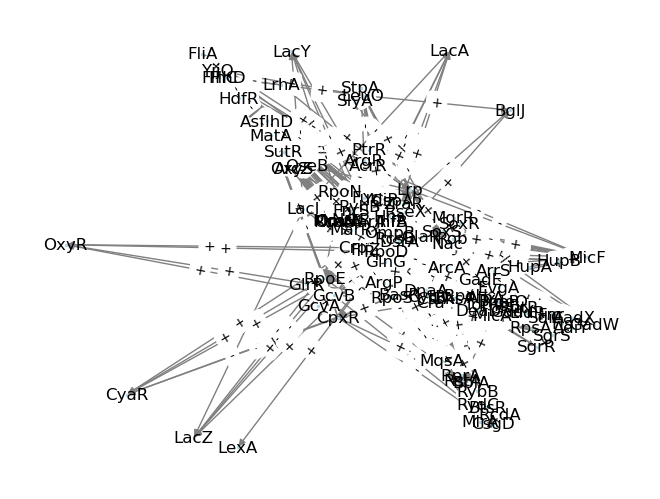

Parameter values before passing to create_dataframes_for_sergio_inputs_from_one_replica: {b_RutR: 0, b_BglJ: 0, b_IhfB: 0, b_Rob: 0, b_GadE: 0, b_RpoE: 0, b_CsgD: 0, b_HupA: 0, b_SutR: 0, b_ArgP: 0, b_OmpR: 0, b_CsrA: 0, b_PhoB: 0, b_OxyR: 0, b_MatA: 0, b_RcsB: 0, b_YjjQ: 0, b_RpoH: 0, b_RydC: 0, b_GlnG: 0, b_FlhC: 0, b_DeaD: 0, b_Fur: 0, b_AcrR: 0, b_Hns: 0, b_RpsA: 0, b_RybB: 0, b_PtrR: 0.6571665940854587, b_OmrB: 1.8455433098515466, b_LeuO: 0, b_DksA: 0, b_MicF: 0, b_AlpA: 0.39328584300147873, b_Cra: 0.716990051933668, b_RcsA: 0, b_SdiA: 0, b_GlaR: 1.372074930391989, b_RyhB: 0, b_SgrR: 0, b_LacZ: 0, b_OmrA: 1.0986793521442408, b_CspA: 0, b_ZraR: 0, b_SlyA: 0, b_HdfR: 0, b_RpoS: 0, b_DnaA: 0, b_BasR: 1.7731783117109992, b_ArcA: 0, b_CytR: 0, b_YdeO: 0, b_GcvB: 0, b_RcdA: 0.5308977275808986, b_GlrR: 1.6025723508839964, b_RseX: 1.2903841540039473, b_MarR: 0, b_CpxR: 0, b_BolA: 0, b_AdiY: 0, b_BtsR: 1.1694473020527905, b_LacA: 0, b_McaS: 0, b_Lrp: 0, b_Fnr: 0, b_NsrR: 0.4543078930105471

In [52]:

# Call the generate_sergio_single function with the graph and parameters
generate_sergio_single(
    target_gene="LacI",
    gene_network=ecoli_network,
    base_param_distributions=base_param_distributions,
    targets_filename='LacI_all_ancestors_targets_1_bin.csv',
    regs_filename='LacI_all_ancestors_regs_1_bin.csv',
    seed=42,
    draw_network_layout=True,  # Disable drawing for the test
    network_filename="LacI_all_ancestors_graph_1_bin.graphml",
    data_filename="LacI_all_ancestors_equations_1_bin.txt"
)

In [58]:
generate_sergio_data(target_gene="LacI",
                gene_network=ecoli_network,
                base_param_distributions=base_param_distributions,
                n_replicas=3,
                targets_filename='LacI_all_ancestors_targets_3_bins.csv',
                regs_filename='LacI_all_ancestors_regs_3_bins.csv',
                seed=42,
                draw_network_layout=False,  # Disable drawing for the test
                network_filename="LacI_all_ancestors_graph_3_bins.graphml",
                data_filename="LacI_all_ancestors_equations_3_bins.txt"
                )


All parameter values dict: {0: {b_RutR: 0, b_BglJ: 0, b_IhfB: 0, b_Rob: 0, b_GadE: 0, b_RpoE: 0, b_CsgD: 0, b_HupA: 0, b_SutR: 0, b_ArgP: 0, b_OmpR: 0, b_CsrA: 0, b_PhoB: 0, b_OxyR: 0, b_MatA: 0, b_RcsB: 0, b_YjjQ: 0, b_RpoH: 0, b_RydC: 0, b_GlnG: 0, b_FlhC: 0, b_DeaD: 0, b_Fur: 0, b_AcrR: 0, b_Hns: 0, b_RpsA: 0, b_RybB: 0, b_PtrR: 2.17386721617813, b_OmrB: 0.3390550517706009, b_LeuO: 0, b_DksA: 0, b_MicF: 0, b_AlpA: 1.4317151711358436, b_Cra: 1.0932830958015296, b_RcsA: 0, b_SdiA: 0, b_GlaR: 0.5375045643794011, b_RyhB: 0, b_SgrR: 0, b_LacZ: 0, b_OmrA: 1.4130194000192302, b_CspA: 0, b_ZraR: 0, b_SlyA: 0, b_HdfR: 0, b_RpoS: 0, b_DnaA: 0, b_BasR: 0.5311604857310319, b_ArcA: 0, b_CytR: 0, b_YdeO: 0, b_GcvB: 0, b_RcdA: 1.3057374737006722, b_GlrR: 0.6632416050341836, b_RseX: 0.830936858022364, b_MarR: 0, b_CpxR: 0, b_BolA: 0, b_AdiY: 0, b_BtsR: 1.0536339523313913, b_LacA: 0, b_McaS: 0, b_Lrp: 0, b_Fnr: 0, b_NsrR: 1.5600573214659565, b_RpoN: 0, b_TorR: 0, b_IhfA: 0, b_LacY: 0, b_FliA: 0, b_G

### TyrR

In [60]:
# get subgraph for "TyrR"

# Call the generate_sergio_single function with the graph and parameters
generate_sergio_single(
    target_gene="TyrR",
    gene_network=ecoli_network,
    base_param_distributions=base_param_distributions,
    targets_filename='TyrR_all_ancestors_targets_1_bin.csv',
    regs_filename='TyrR_all_ancestors_regs_1_bin.csv',
    seed=42,
    draw_network_layout=False,  # Disable drawing for the test
    network_filename="TyrR_all_ancestors_graph_1_bin.graphml",
    data_filename="TyrR_all_ancestors_equations_1_bin.txt"
)

generate_sergio_data(target_gene="TyrR",
                gene_network=ecoli_network,
                base_param_distributions=base_param_distributions,
                n_replicas=3,
                targets_filename='TyrR_all_ancestors_targets_3_bins.csv',
                regs_filename='TyrR_all_ancestors_regs_3_bins.csv',
                seed=42,
                draw_network_layout=False,  # Disable drawing for the test
                network_filename="TyrR_all_ancestors_graph_3_bins.graphml",
                data_filename="TyrR_all_ancestors_equations_3_bins.txt"
                )

Parameter values before passing to create_dataframes_for_sergio_inputs_from_one_replica: {b_PgrR: 1.0392400324971258, b_RutR: 0, b_BglJ: 0, b_IhfB: 0, b_Rob: 0, b_GadE: 0, b_RpoE: 0, b_CsgD: 0, b_HupA: 0, b_SutR: 0, b_ArgP: 0, b_OmpR: 0, b_TyrR: 0, b_CsrA: 0, b_PhoB: 0, b_AroM: 0, b_OxyR: 0, b_MatA: 0, b_RcsB: 0, b_YjjQ: 0, b_FolA: 0, b_RpoH: 0, b_RydC: 0, b_GlnG: 0, b_Mtr: 0, b_FlhC: 0, b_DeaD: 0, b_Fur: 0, b_AcrR: 0, b_Hns: 0, b_PtrR: 2.34493902636694, b_RybB: 0, b_RpsA: 0, b_OmrB: 1.5777148780217574, b_LeuO: 0, b_DksA: 0, b_TyrA: 0, b_MicF: 0, b_AlpA: 2.3126381855255365, b_Cra: 0.5007661518583051, b_RcsA: 0, b_SdiA: 0, b_GlaR: 0.5330556153435734, b_RyhB: 0, b_SgrR: 0, b_AroG: 0, b_OmrA: 0.7989982160360455, b_CspA: 0, b_ZraR: 0, b_SlyA: 0, b_HdfR: 0, b_RpoS: 0, b_DnaA: 0, b_BasR: 2.085530163624915, b_ArcA: 0, b_CytR: 0, b_YdeO: 0, b_GcvB: 0, b_RcdA: 0.8924873955959821, b_RseX: 1.0028760545770026, b_GlrR: 0.5326429753938127, b_MarR: 0, b_CpxR: 0, b_BolA: 0, b_AdiY: 0, b_BtsR: 1.079958

### FadR

In [59]:
# get subgraph for "FadR"

# Call the generate_sergio_single function with the graph and parameters
generate_sergio_single(
    target_gene="FadR",
    gene_network=ecoli_network,
    base_param_distributions=base_param_distributions,
    targets_filename='FadR_all_ancestors_targets_1_bin.csv',
    regs_filename='FadR_all_ancestors_regs_1_bin.csv',
    seed=42,
    draw_network_layout=False,  # Disable drawing for the test
    network_filename="FadR_all_ancestors_graph_1_bin.graphml",
    data_filename="FadR_all_ancestors_equations_1_bin.txt"
)

generate_sergio_data(target_gene="FadR",
                gene_network=ecoli_network,
                base_param_distributions=base_param_distributions,
                n_replicas=3,
                targets_filename='FadR_all_ancestors_targets_3_bins.csv',
                regs_filename='FadR_all_ancestors_regs_3_bins.csv',
                seed=42,
                draw_network_layout=False,  # Disable drawing for the test
                network_filename="FadR_all_ancestors_graph_3_bins.graphml",
                data_filename="FadR_all_ancestors_equations_3_bins.txt"
                )

Parameter values before passing to create_dataframes_for_sergio_inputs_from_one_replica: {b_RutR: 0, b_BglJ: 0, b_FadI: 0, b_IhfB: 0, b_Rob: 0, b_GadE: 0, b_RpoE: 0, b_CsgD: 0, b_HupA: 0, b_SutR: 0, b_ArgP: 0, b_OmpR: 0, b_FabG: 0, b_CsrA: 0, b_PhoB: 0, b_FabH: 0, b_OxyR: 0, b_MatA: 0, b_RcsB: 0, b_YjjQ: 0, b_RpoH: 0, b_RydC: 0, b_AccD: 0, b_GlnG: 0, b_FlhC: 0, b_DeaD: 0, b_Fur: 0, b_AcrR: 0, b_FadD: 0, b_FadL: 0, b_Hns: 0, b_RpsA: 0, b_PtrR: 0.6398703032399675, b_RybB: 0, b_OmrB: 2.201132312246529, b_LeuO: 0, b_DksA: 0, b_FadR: 0, b_MicF: 0, b_FabI: 0, b_AlpA: 0.44378115037359206, b_Cra: 2.0395865671682283, b_RcsA: 0, b_SdiA: 0, b_GlaR: 0.7090815178909782, b_RyhB: 0, b_C0293: 0.7931618876533778, b_SgrR: 0, b_AceA: 0, b_AccB: 0, b_OmrA: 1.5049471528541998, b_CspA: 0, b_ZraR: 0, b_SlyA: 0, b_HdfR: 0, b_RpoS: 0, b_DnaA: 0, b_BasR: 2.17386721617813, b_ArcA: 0, b_CytR: 0, b_YdeO: 0, b_GcvB: 0, b_RcdA: 0.3390550517706009, b_GlrR: 1.4317151711358436, b_RseX: 1.0932830958015296, b_MarR: 0, b_

# Cytoscape visualization demo

In [ ]:
import ipycytoscape

def draw_cytoscape_network(G):
    # Create a Cytoscape graph
    cyto_graph = ipycytoscape.CytoscapeWidget()

    # Calculate the positions of the nodes using the spring layout algorithm
    pos = nx.spring_layout(G)

    # Add nodes with labels and positions
    for node in G.nodes():
        cyto_node = ipycytoscape.Node(data={"id": node, "label": str(node)}, 
                                      position={'x': pos[node][0], 'y': pos[node][1]})
        cyto_graph.graph.add_node(cyto_node)

    # Add edges with polarity attribute
    for edge in G.edges(data=True):
        source, target, data = edge
        cyto_edge = ipycytoscape.Edge(data={"source": source, "target": target, "polarity": data['polarity']})
        cyto_graph.graph.add_edge(cyto_edge)

    # Define a style for the edges
    edge_style = [
        {
            'selector': 'edge[polarity = "+"]',
            'style': {
                'line-color': 'green',
                'curve-style': 'bezier',
                'target-arrow-shape': 'triangle',
                'target-arrow-color': 'green'
            }
        },
        {
            'selector': 'edge[polarity = "-"]',
            'style': {
                'line-color': 'red',
                'curve-style': 'bezier',
                'target-arrow-shape': 'triangle',
                'target-arrow-color': 'red'
            }
        },
        {
            'selector': 'edge[polarity = "+/-"]',
            'style': {
                'line-color': 'black',
                'curve-style': 'bezier',
                'target-arrow-shape': 'triangle',
                'target-arrow-color': 'black'
            }
        }
    ]

    # Define a style for the nodes to display the labels
    node_style = [
        {
            'selector': 'node',
            'style': {
                'label': 'data(label)'
            }
        }
    ]

    # Apply the styles to the graph
    cyto_graph.set_style(edge_style + node_style)

    # Display the graph
    return cyto_graph

subgraph = process_graph(ecoli_network, ['TyrR'], descendants_only=True, full_network_name="ecoli", print_results=False, save_results=False, plot_subgraph=False)

cyto_graph = draw_cytoscape_network(subgraph)

cyto_graph